# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> AC221 Critical Thinking in Data Science
## Final Project - Michael Downs & Daniel Cox

### Do data cleaning & anonymization affect model agnostic interpretability techniques?


**Spring 2020**<br/>



<hr style="height:2pt">

# <mark style="color:red;">Note: Please run the appendix code before the main body of the notebook.</mark>

## Table of Contents (double check that this works)

* [Introduction](#Introduction)
    * [Overview](#Overview)
    * [Data Anonymization Techniques](#Data-Anonymization-Techniques)
    * [Data Cleaning Techniques](#Data-Cleaning-Techniques)
    * [Interpretability](#Interpretability)
* [The EdX Data](#The-EdX-Data)
    * [Data Cleaning](#Data-Cleaning)
    * [5-anonymous: Suppression](#5-anonymous:-Suppression)
    * [5-anonymous: Synthetic Record Generation](#5-anonymous:-Synthetic-Record-Generation)
    * [5-anonymous: Synthetic Record Generation (alternate)](#5-anonymous:-Synthetic-Record-Generation-(alternate))
    * [5-anonymous: Blurring and Generalization](#5-anonymous:-Blurring-and-Generalization)
    * [Alternate Imputation](#Alternate-Imputation)
    * [Random Duplicates](#Random-Duplicates)
    * [Systematic Duplicates](#Systematic-Duplicates)
    * [EDA](#EDA)
    * [Modeling](#Modeling)
* [Experiments](#Experiments)
    * [Partial Dependence](#Partial-Dependence)
    * [Friedman's H-Statistic](#Friedman's-H-Statistic)
    * [Permutation Importance](#Permutation-Importance)
    * [Global Surrogates](#Global-Surrogates)
* [Conclusion & Future Work](#Conclusion-&-Future-Work)   
* [References](#References)
* [Appendix](#Appendix)





In [6]:
import numpy as np
from random import seed

np.random.seed(42)
seed(42)

## Introduction






### Overview

In this project, we empirically assess the effects of modifying a dataset through anonymization and cleaning on the output of several model-agnostic interpretability techniques including: permutation, feature importance, partial dependence, global surrogates, and Friedman’s H-Statistic for feature interaction. 

We have observed how anonymization and data cleaning can change the results of statistical analyses and introduce bias into a dataset. We hypothesize that such modifications would also have an effect on the results of the techniques used to interpret the predictions made by black-box machine learning models, potentially causing the users of these techniques to make spurious inferences. 

An increasing number of these black-box systems have been put in place to automate decisions of societal importance, such as who is able to take out a loan. The ability to reliably understand how these systems came to a particular decision is of the utmost importance to enable fairness and transparency. As black box models are not inherently interpretable, these model-agnostic techniques, which depend only on model input and output, provide the only means to make them interpretable. We believe that it is important to understand how changing the data that feeds these models can affect the explanations provided by these techniques.

Using a dataset created from a subset of the EdX data pertaining to a particular course, we compare the differences in the output of the aforementioned four techniques between a clean version of the dataset and several different versions that have been in various ways anonymized or degraded.

We found that there are indeed differences in the output of these interpretability techniques that could drive the generation of different hypotheses when compared with the original output.

### Data Anonymization Techniques

In PS2 we explored the effects of anonymization on dataset integrity.                                                      

Some definitions:

An identifier is a data element which directly identifies an individual. An example would be a person'a name or an ID.

A quasi-identifier is a data element which does not directly identify an individual but provides information as to who they might be. For example, gender and age are quasi-identifiers.

A dataset is said to be k-anonymous if there are at least k copies of each set of values for the quasi-identifiers in the dataset. A higher k means that privacy is better protected, but using a k that is too high might degrade the quality of statistical analyses performed on the anonymized dataset. 5-anonymity is a standard value which yields a good tradeoff between privacy and data integrity.

Some methods to achieve k-anonymity are:

* suppression: Which involves dropping records from a dataset 
* synthetic record generation: Which involves generating records 
* blurring: Which involves dropping columns from a dataset 
* generalizing: Which involves making a column less granular (i.e. city -> state)

We observed in PS2 that generalizing, blurring, and suppressing records distorted statistics such as the completion rate for each course. We expect these techniques to also modify interpretability. For example, suppression can remove the interesting and unique cases in the dataset, and adding synthetic records might make a particular trend more prominent than it otherwise would be.

### Data Cleaning Techniques


We performed a similar analysis in PS3 by cleaning the dataset through removing duplicate values, imputing missing values, and removing corrupt values. We would expect these data cleaning techniques to change the interpretation of a model as well. 

For our experiments, we start with a "clean" dataset and produce versions that are degraded somehow e.g. they have duplicates added or use inferior imputation techniques. We assess the the interpretability metrics on these degraded datasets for differences.





### Interpretability

A model is said to be interpretable if a human can understand how it made its decision. A model is either directly interpretable or can be made interpretable through model agnostic technique. For example, decision trees and linear models are inherently interpretable. A single decision tree with only a few levels provides a series of if-then rules in order to reach its prediction, which a human can logically follow. A linear regression model additively combines weighted feature values to reach a prediction, which a human can follow. The values of the regression coefficients correspond to effect sizes and the p-values of the regression coeeficients correspond to feature importance. 

It is nigh impossible, however, for a human to follow the process by which a random forest with many predictors or a deep neural network made their predictions using only the components of the models themselves. Furthermore, these "black-box" models do not by default describe which features matter for prediction and what their effect on the prediction is. Model-agnostic techniques, which depend only on the inputs and outputs of a model offer a means  to interpret these black-box models. Many of these techniques follow the pattern of perturbing the input to a trained model in a particular manner and then seeing how the output changes. Because black-box models tend to be more powerful than inherently interpretable models, they are often of more practical interest. Model-agnostic techniques allow us to make these black-box models interpretable while not sacrificing their predictive power.

The four techniques we explore in this project are:

* Partial Dependence: Which answers the question: what the effect of certain feature on the prediction?
* Friedman's H-Statistic: Which answers the questions: is there an interaction effect for certain features?
* Permutation Importance: Which answers the question: which features matter most for prediction?
* Global Surrogates: Which use a directly interpretable model to explain what a black-box model is doing.



## The EdX Data

Our case study is the binary prediction task of determining whether a user will pass a particular course present in the edX data, HarvardX/ER22x/2013_Spring. The subset of the edX dataset corresponding to this course is around 15k records. This course had the highest product of number of enrolled students and percentage of students passing. Because the overall average pass rate was 2%, we worried that there would be class imbalance issues, so we wanted to pick a subset of the dataset that was sufficiently large and did not have as severe class imbalance. Around 6% of the students who took HarvardX/ER22x/2013_Spring passed it.

In our experiments that require increasing the size of the dataset, we use at most 50k records. We do not use the entire dataset of ~1 million records because of the aforementioned class imbalance concern and because some of these interpretability techniques are computationally intensive and we wanted to decrease the latency in the experimentation loop of training a model, running the interpretability algorithms, and assessing the output.  

We used the features:

* cc_by_ip: country code
* un_economic_group: developed/undeveloped
* LoE: level of education
* YoB: year of birth, converted to age quintiles
* gender
* nevents: the total number of events in the tracking logs for a user
* ndays_act: the total number of days that the user was active
* nchapters: the total number of chapters (of course content?) visited by the user
* nforum_posts: the total number of forum posts made by the user
* is_active: whether or not the user was still active as of when the edX dataset was released
* sum_dt: the total time that the user spent on the course


Our analysis is diagnostic, not predictive, so we view it as permissible to use features that would only have been created during the course and not just those that are immediately available at the outset of the course.

Please see the appendix for a description of all of the fields available in the edX dataset.

The fields we consider to be quasi-identifiers are:

* cc_by_ip
* LoE
* YoB
* gender
* nforum_posts

### Data Cleaning

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv('./data/PS2_data.csv')

target = 'completed'

/Users/michaeldowns/miniconda3/envs/ac221/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (49,50,64) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
df_cs50 = df.query("course_id.str.lower().str.contains('cs50')", engine='python')

print(f"Overall fraction of users completing a course: {100*df.completed.mean():.4f}%")
print(f"Overall fraction of users completing a cs50 course: {100*df_cs50.completed.mean():.4f}%")

Overall fraction of users completing a course: 2.4648%
Overall fraction of users completing a cs50 course: 0.2206%


We observe that the overall course completion rate is low so we look for a course that has reasonably high enrollment and also a less imbalanced completion rate. We sort all courses by the product of enrollment and completion rate.

In [9]:
with pd.option_context('max_rows', 999):
    counts_completion_rates_df = (df
                                      .groupby('course_id')
                                      .completed.agg(['count', 'mean'])
                                      .assign(count_completion_rate=lambda df: df['count']*df['mean'])
                                      .sort_values(by='count_completion_rate', ascending=False)
                                 )
    display(counts_completion_rates_df)

,count,mean,count_completion_rate
course_id,,,
HarvardX/ER22x/2013_Spring,15396,0.061899,953.0
HarvardX/SPU30x/2T2016,13461,0.060397,813.0
HarvardX/PH207x/2012_Fall,14207,0.056240,799.0
HarvardX/PH125.1x/3T2017,9018,0.085274,769.0
HarvardX/GSE2x/2T2014,10801,0.059902,647.0
HarvardX/PH201x/2013_SOND,9074,0.064580,586.0
HarvardX/SW12x/2013_SOND,13389,0.043020,576.0
HarvardX/PH525.1x/1T2015,6949,0.065621,456.0
HarvardX/SW12.2x/1T2014,7663,0.059376,455.0


In [10]:
df_er22x = df.query("course_id == 'HarvardX/ER22x/2013_Spring'", engine='python')

We focus our attention on a particular course, err22x, on justice, which had the highest completion percent and enrollment product. 

In [11]:
identifiers = [
    'user_id'
]

raw_features = [
    'cc_by_ip', 
    'un_economic_group', 
    'LoE', 
    'YoB', 
    'gender', 
    'nevents', 
    'ndays_act', 
   # 'nplay_video',  # is always 0
    'nchapters',
    'nforum_posts', 
    'is_active',
   # 'language_brwsr',  # is mostly null
    'sum_dt', 
]

In [12]:
df_raw_feats = df_er22x[identifiers + [target] + raw_features]

df_raw_feats.head()

,user_id,completed,cc_by_ip,un_economic_group,LoE,YoB,gender,nevents,ndays_act,nchapters,nforum_posts,is_active,sum_dt
287750,1656257,False,US,Developed regions,NaN,NaN,NaN,5.0,2.0,1.0,NaN,1.0,11.282710
287751,5607339,False,US,Developed regions,NaN,NaN,NaN,16.0,3.0,2.0,NaN,1.0,38.026620
287752,2265042,False,CA,Developed regions,NaN,NaN,NaN,116.0,5.0,4.0,NaN,1.0,1503.446461
287753,5445391,False,IN,Developing_Nations,NaN,NaN,NaN,425.0,22.0,12.0,NaN,NaN,2850.476235
287754,3535881,False,SI,Developed regions,NaN,NaN,NaN,26.0,6.0,2.0,NaN,NaN,148.872184


We chose the features which we thought might be relevant for determining whether a student will pass er22x.

In [13]:
# used to make the LoE feature more readable.
loe_map = {
            'p': 'phd',
            'm': 'masters',
            'b': 'bachelors',
            'a': 'associates',
            'hs': 'high_school',
            'jhs': 'junior_high_school',
            'el': 'elementary_primary',
            'none': 'no_formal_ed',
            'other': 'unspecified',
            'p_se': 'phd',
            'p_oth': 'phd',
            'UNKNOWN': 'UNKNOWN'
          }             

In [14]:
df_raw_feats.isnull().sum()

user_id                  0
completed                0
cc_by_ip               624
un_economic_group      620
LoE                   1307
YoB                   1438
gender                1245
nevents                943
ndays_act              942
nchapters             5653
nforum_posts         13254
is_active             1327
sum_dt                3910
dtype: int64

There are a lot of null values. Let's try to fix that. We add a new category, "UNKNOWN", to the categorical features and also impute all of the numeric features to be 0. The latter imputation is justified because there are no cases of a user passing with a NaN value for one of the numeric features.

In [15]:
df_raw_feats = df_er22x[identifiers + [target] + raw_features]

df_raw_feats.loc[:, ['cc_by_ip']] = df_raw_feats.cc_by_ip.fillna('UNKNOWN')
df_raw_feats.loc[:, ['un_economic_group']] = (df_raw_feats
                                              .un_economic_group
                                              .replace('Developed regions', 'developed')
                                              .replace('Developing_Nations', 'developing')
                                              .fillna('UNKNOWN')) 

df_raw_feats.loc[:, ['LoE']] = df_raw_feats.LoE.fillna('UNKNOWN').apply(lambda x: loe_map[x])
df_raw_feats.loc[:, 'age'] = (pd
                                  .qcut(2013 - df_raw_feats.YoB, 5)
                                  .astype('object')
                                  .fillna('UNKNOWN'))

df_raw_feats.loc[:, 'gender'] = df_raw_feats.gender.fillna('UNKNOWN')
df_raw_feats.loc[:, 'is_active'] = df_raw_feats.is_active.fillna('UNKNOWN')


# I checked to see whether any users who had NaNs for their numeric fields passed -- they did not
df_raw_feats.loc[:, 'nevents'] = df_raw_feats.nevents.fillna(0.0)
df_raw_feats.loc[:, 'ndays_act'] = df_raw_feats.ndays_act.fillna(0.0)
df_raw_feats.loc[:, 'nchapters'] = df_raw_feats.nchapters.fillna(0.0)
df_raw_feats.loc[:, 'nforum_posts'] = df_raw_feats.nforum_posts.fillna(0.0)
df_raw_feats.loc[:, 'sum_dt'] = df_raw_feats.sum_dt.fillna(0.0)

order = [
    'user_id',
    'completed',
    'cc_by_ip',
    'un_economic_group', 
    'LoE', 
    'age',
    'gender',
    'is_active',
    'nevents', 
    'ndays_act',
    'nchapters', 
    'nforum_posts', 
    'sum_dt'
]

renaming = {
    'cc_by_ip': 'country_code',
    'un_economic_group': 'economic_group',
    'LoE': 'level_of_education',
    'nevents': 'num_log_events',
    'ndays_act': 'num_days_active',
    'nchapters': 'num_chapters_visited',
    'nforum_posts': 'num_forum_posts',
    'is_active': 'still_active',
    'sum_dt': 'total_time_seconds'
}

target = 'completed'

categorical_feats = [
    'country_code',
    'economic_group', 
    'level_of_education', 
    'age',
    'gender',
    'still_active',
]

numeric_feats = [
    'num_log_events', 
    'num_days_active',
    'num_chapters_visited', 
    'num_forum_posts', 
    'total_time_seconds'
]

quasi_identifiers = [
    'country_code', 
    'level_of_education', 
    'age', 
    'gender', 
    'num_forum_posts'
]

df_feats = (df_raw_feats
                .drop(columns=['YoB'])
                [order]
                .rename(columns=renaming))

/Users/michaeldowns/miniconda3/envs/ac221/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/michaeldowns/miniconda3/envs/ac221/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [16]:
df_feats.isnull().sum()

user_id                 0
completed               0
country_code            0
economic_group          0
level_of_education      0
age                     0
gender                  0
still_active            0
num_log_events          0
num_days_active         0
num_chapters_visited    0
num_forum_posts         0
total_time_seconds      0
dtype: int64

We now make several alternate versions of the cleaned dataset that either 

* satisfy some privacy requirement
* represent how an uncleaned version of the dataset might look
* or use different imputation methodologies.

# 5-anonymous: Suppression

In [17]:
df_feats.sort_values(by=quasi_identifiers).to_csv('./data/data_sorted.csv', index=False)

suppression_fast(df_feats, quasi_identifiers)

df_5a_sup = pd.read_csv('./data/dataset_5_anonymous_sup.csv')

num_records_lost = len(df_feats) - len(df_5a_sup)

print(f"After suppression, {num_records_lost} records were lost, or {100* num_records_lost/len(df_feats):.2f}% of the data")
print(f"The 5-anonymous dataset has {len(df_5a_sup)} records, down from {len(df_feats)}")
print(f"After suppression, the completion rate is now {100*df_5a_sup.completed.mean():.2f}% down from {100*df_feats.completed.mean():.2f}%")


Writing to ./data/dataset_5_anonymous_sup.csv



After suppression, 5286 records were lost, or 34.33% of the data
The 5-anonymous dataset has 10110 records, down from 15396
After suppression, the completion rate is now 3.29% down from 6.19%


We expect that the suppression has removed users from the less-well-represented countries in the dataset.

# 5-anonymous: Synthetic Record Generation

In [18]:
feature_fields = [
    'completed', 
    'still_active', 
    'num_log_events',
    'num_days_active', 
    'num_chapters_visited',
    'total_time_seconds'
]

synthetic_records = SyntheticRecords(df_feats, feature_fields)

synthetic_fast(df_feats, quasi_identifiers, synthetic_records)

df_5a_syn = pd.read_csv('./data/dataset_5_anonymous_syn.csv')

num_records_gained = len(df_5a_syn) - len(df_feats)

print(f"After synthetic record generation, {num_records_gained} records were gained, an increase by a factor of {1 + num_records_gained/len(df_feats)}")
print(f"The 5-anonymous dataset has {len(df_5a_syn)} records, up from {len(df_feats)}")
print(f"After synthetic record generation, the completion rate is now {100*df_5a_syn.completed.mean():.2f}%. original: {100*df_feats.completed.mean():.2f}%")






Shuffling user IDs
Finished shuffling user IDs in 7.727328062057495 seconds
Making fake records
Finished making fake records in 0.825700044631958 seconds



After synthetic record generation, 13164 records were gained, an increase by a factor of 1.8550272798129384
The 5-anonymous dataset has 28560 records, up from 15396
After synthetic record generation, the completion rate is now 6.25%. original: 6.19%


We would expect the effect of generating synthetic records in this manner to be to de-correlate to some degree the quasi-identifiers with the target.

# 5-anonymous: Synthetic Record Generation (alternate)

In order to illustrate how augmenting a dataset with synthetic records could affect model interpretability metrics, we produce an alternative version of the dataset above that produces synthetic records by preserving the original value of "completed". This preserves the relationship between completed and the quasi identifiers, but partially breaks it for the remaining features. 

In [19]:
feature_fields = [
  #  'completed', 
    'still_active', 
    'num_log_events',
    'num_days_active', 
    'num_chapters_visited',
    'total_time_seconds'
]

synthetic_records = SyntheticRecords(df_feats, feature_fields)

synthetic_fast(df_feats, quasi_identifiers, synthetic_records, outfile='dataset_5_anonymous_syn_alt.csv')

df_5a_syn_alt = pd.read_csv('./data/dataset_5_anonymous_syn_alt.csv')

num_records_gained = len(df_5a_syn_alt) - len(df_feats)

print(f"After synthetic record generation, {num_records_gained} records were gained, an increase by a factor of {1 + num_records_gained/len(df_feats)}")
print(f"The 5-anonymous dataset has {len(df_5a_syn_alt)} records, up from {len(df_feats)}")
print(f"After synthetic record generation, the completion rate is now {100*df_5a_syn_alt.completed.mean():.2f}%. original: {100*df_feats.completed.mean():.2f}%")




Shuffling user IDs
Finished shuffling user IDs in 7.836548805236816 seconds
Making fake records
Finished making fake records in 0.7738592624664307 seconds



After synthetic record generation, 13164 records were gained, an increase by a factor of 1.8550272798129384
The 5-anonymous dataset has 28560 records, up from 15396
After synthetic record generation, the completion rate is now 10.28%. original: 6.19%


# 5-anonymous: Blurring and Generalization


We greedily take the 3 columns that yield the greatest gain in k-anonymity and also further generalize age to make it a binary indicator for whether someone is over 40.

In [20]:
best_cols = blur_dataset(df_feats, 
             5, 
             quasi_identifiers, 
             iters=3)

new_cols = list(set(df_feats.columns) - set(best_cols))

df_blurred = df_feats[new_cols]

get_num_records_k_anonymous(df_blurred, 5, quasi_identifiers)

# We also further generalize age

def generalize_age(age):
    # Converts age to over 40, under 41, and unknown
    if age == 'UNKNOWN':
        return 'UNKNOWN'
    elif str(age) in ['(-0.001, 22.0]', '(22.0, 25.0]', '(25.0, 30.0]', '(30.0, 40.0]']:
        return False
    else:
        return True
    
print(df_blurred.age.value_counts())
    
df_blurred.loc[:, 'age'] = df_blurred.age.apply(generalize_age)
df_blurred_generalized = df_blurred


print(f"Number of records that are 5-anonymous: {get_num_records_k_anonymous(df_blurred_generalized, 5, quasi_identifiers)}")
print(f"Number of records: {len(df_blurred_generalized)}")

# We drop the remaining non 5-anonymous records

groupbycols = set(df_blurred_generalized.columns) & set(quasi_identifiers)

df_blurred_generalized = df_blurred_generalized.groupby(list(groupbycols)).filter(lambda df: len(df) >= 5)

print(f"Number of records that are 5-anonymous: {get_num_records_k_anonymous(df_blurred_generalized, 5, quasi_identifiers)}")
print(f"Number of records: {len(df_blurred_generalized)}")

Performing blurring for k=5
BLURRING ITERATION 0
country_code resulted in the largest increase of k anonymous records of 4370
BLURRING ITERATION 1
num_forum_posts resulted in the largest increase of k anonymous records of 797
BLURRING ITERATION 2
level_of_education resulted in the largest increase of k anonymous records of 106
(-0.001, 22.0]    3511
(25.0, 30.0]      2797
(40.0, 117.0]     2724
(30.0, 40.0]      2654
(22.0, 25.0]      2272
UNKNOWN           1438
Name: age, dtype: int64
Number of records that are 5-anonymous: 15391
Number of records: 15396
Number of records that are 5-anonymous: 15391
Number of records: 15391


# Alternate Imputation


We use an alternate and arguably inferior imputation method:

* For categoricals, we ue the most common class
* For numeric fields, we use the mean

In [21]:
df_raw_feats = df_er22x[identifiers + [target] + raw_features]

df_raw_feats.loc[:, ['cc_by_ip']] = df_raw_feats.cc_by_ip.fillna(df_raw_feats.cc_by_ip.value_counts().index[0])

df_raw_feats.loc[:, ['un_economic_group']] = (df_raw_feats
                                              .un_economic_group
                                              .fillna(df_raw_feats.un_economic_group.value_counts().index[0])
                                              .replace('Developed regions', 'developed')
                                              .replace('Developing_Nations', 'developing')
                                             ) 

df_raw_feats.loc[:, ['LoE']] = (df_raw_feats
                                    .LoE
                                    .fillna(df_raw_feats.LoE.value_counts().index[0])
                                    .apply(lambda x: loe_map[x])
                               )


df_raw_feats.loc[:, 'age'] = (pd
                                  .qcut(2013 - df_raw_feats.YoB, 5)
                                  .astype('object')
                             )

df_raw_feats.loc[:, ['age']] = df_raw_feats.age.fillna(df_raw_feats.age.value_counts().index[0])

df_raw_feats.loc[:, 'gender'] = df_raw_feats.gender.fillna(df_raw_feats.gender.value_counts().index[0])
df_raw_feats.loc[:, 'is_active'] = df_raw_feats.is_active.fillna(df_raw_feats.is_active.value_counts().index[0])

# I checked to see whether any users who had NaNs for their numeric fields passed -- they did not
df_raw_feats.loc[:, 'nevents'] = df_raw_feats.nevents.fillna(df_raw_feats.nevents.mean())
df_raw_feats.loc[:, 'ndays_act'] = df_raw_feats.ndays_act.fillna(df_raw_feats.nevents.mean())
df_raw_feats.loc[:, 'nchapters'] = df_raw_feats.nchapters.fillna(df_raw_feats.nevents.mean())
df_raw_feats.loc[:, 'nforum_posts'] = df_raw_feats.nforum_posts.fillna(df_raw_feats.nevents.mean())
df_raw_feats.loc[:, 'sum_dt'] = df_raw_feats.sum_dt.fillna(df_raw_feats.sum_dt.mean())

order = [
    'user_id',
    'completed',
    'cc_by_ip',
    'un_economic_group', 
    'LoE', 
    'age',
    'gender',
    'is_active',
    'nevents', 
    'ndays_act',
    'nchapters', 
    'nforum_posts', 
    'sum_dt'
]

renaming = {
    'cc_by_ip': 'country_code',
    'un_economic_group': 'economic_group',
    'LoE': 'level_of_education',
    'nevents': 'num_log_events',
    'ndays_act': 'num_days_active',
    'nchapters': 'num_chapters_visited',
    'nforum_posts': 'num_forum_posts',
    'is_active': 'still_active',
    'sum_dt': 'total_time_seconds'
}

target = 'completed'

categorical_feats = [
    'country_code',
    'economic_group', 
    'level_of_education', 
    'age',
    'gender',
    'still_active',
]

numeric_feats = [
    'num_log_events', 
    'num_days_active',
    'num_chapters_visited', 
    'num_forum_posts', 
    'total_time_seconds'
]

quasi_identifiers = [
    'country_code', 
    'level_of_education', 
    'age', 
    'gender', 
    'num_forum_posts'
]

df_feats_alt_imp = (df_raw_feats
                .drop(columns=['YoB'])
                [order]
                .rename(columns=renaming))

# Random Duplicates


In [22]:


samps = df_feats.sample(n=50000 - len(df_feats), replace=True)

df_feats_duplicates = pd.concat((df_feats, samps), axis=0)
df_feats_duplicates = df_feats_duplicates.sample(frac=1).reset_index(drop=True)
df_feats_duplicates

,user_id,completed,country_code,economic_group,level_of_education,age,gender,still_active,num_log_events,num_days_active,num_chapters_visited,num_forum_posts,total_time_seconds
0,3399415,False,IN,developing,high_school,"(-0.001, 22.0]",m,0,1.0,1.0,0.0,0.0,0.000000
1,4092042,False,JP,developed,bachelors,"(22.0, 25.0]",m,1,26.0,3.0,3.0,0.0,221.015892
2,5254246,False,TR,developing,high_school,"(22.0, 25.0]",f,0,13.0,3.0,2.0,0.0,110.703690
3,7572741,False,NL,developed,junior_high_school,"(-0.001, 22.0]",f,0,0.0,0.0,0.0,0.0,0.000000
4,3247593,False,AU,developed,masters,"(40.0, 117.0]",m,0,56.0,3.0,3.0,0.0,344.976535
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,6448158,False,FR,developed,masters,"(40.0, 117.0]",m,1,5.0,2.0,0.0,0.0,337.317200
49996,1938069,False,US,developed,bachelors,"(40.0, 117.0]",f,1,6.0,3.0,0.0,0.0,163.061917
49997,4622470,False,US,developed,high_school,"(-0.001, 22.0]",f,0,1.0,1.0,0.0,0.0,0.000000
49998,4665053,False,IN,developing,high_school,"(-0.001, 22.0]",m,0,165.0,16.0,3.0,0.0,2141.781973


# Systematic Duplicates

We also assess the scenario where records are not duplicated at random. In this case, only the records for students who visited many chapters but did not complete the course are duplicated.

In [23]:
samps = df_feats.query('~completed & (num_chapters_visited > 15)').sample(n=50000 - len(df_feats), replace=True)

df_feats_duplicates_sys = pd.concat((df_feats, samps), axis=0)
df_feats_duplicates_sys = df_feats_duplicates_sys.sample(frac=1).reset_index(drop=True)
df_feats_duplicates_sys

,user_id,completed,country_code,economic_group,level_of_education,age,gender,still_active,num_log_events,num_days_active,num_chapters_visited,num_forum_posts,total_time_seconds
0,4435285,False,US,developed,masters,"(40.0, 117.0]",m,1,276.0,29.0,22.0,0.0,1476.467845
1,6388077,False,DE,developed,masters,"(22.0, 25.0]",m,0,528.0,15.0,16.0,0.0,6231.306922
2,7621292,False,ES,developed,bachelors,"(30.0, 40.0]",m,0,642.0,25.0,22.0,0.0,4869.932042
3,2198372,False,US,developed,high_school,"(25.0, 30.0]",m,1,439.0,9.0,16.0,0.0,3105.529512
4,6118335,False,MA,developing,bachelors,"(-0.001, 22.0]",m,0,1428.0,12.0,31.0,0.0,12303.281771
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1992343,False,GB,developed,masters,"(40.0, 117.0]",m,1,1102.0,10.0,32.0,0.0,5450.872856
49996,8056561,False,FR,developed,masters,"(22.0, 25.0]",m,1,818.0,20.0,24.0,0.0,9486.777240
49997,1324902,False,US,developed,unspecified,"(40.0, 117.0]",m,1,6.0,3.0,0.0,0.0,110.054805
49998,2128975,False,LU,developed,masters,"(30.0, 40.0]",f,0,277.0,5.0,16.0,0.0,1983.896275


# EDA

We perform EDA on the un-modified dataset to gain intuition for whether the features matter for this prediction task.

In [24]:
df_feats.sample(n=5)

,user_id,completed,country_code,economic_group,level_of_education,age,gender,still_active,num_log_events,num_days_active,num_chapters_visited,num_forum_posts,total_time_seconds
298988,9198711,False,JP,developed,bachelors,"(40.0, 117.0]",m,1,15.0,1.0,2.0,0.0,530.859935
294066,3031659,False,GR,developed,bachelors,"(-0.001, 22.0]",f,1,52.0,2.0,2.0,0.0,1023.765928
301033,6434545,False,JP,developed,phd,"(40.0, 117.0]",m,0,23.0,3.0,2.0,0.0,250.930454
295437,3756419,True,BE,developed,masters,"(30.0, 40.0]",m,1,1504.0,17.0,32.0,2.0,17623.021366
290952,8513019,False,US,developed,high_school,"(30.0, 40.0]",f,1,3.0,3.0,0.0,0.0,0.000000


We now plot the completion rate versus our feature set to see if there's any signal.

In [25]:
print(f"Out of {len(df_feats)} total records with {len(df_feats.user_id.unique())} unique students, {100*df_feats.completed.mean():.2f}% passed the course.")



Out of 15396 total records with 15396 unique students, 6.19% passed the course.


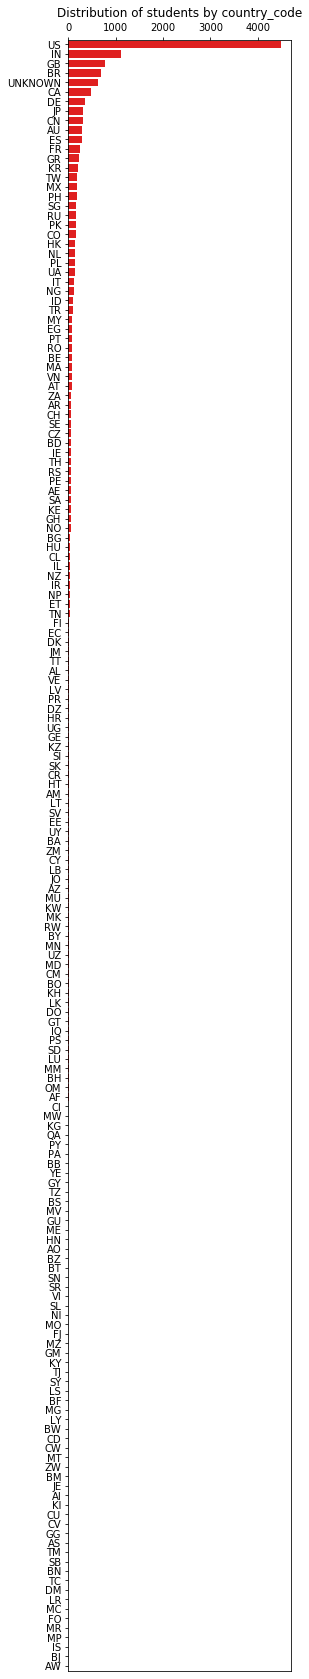

In [26]:


fig, ax = plt.subplots(figsize=(4, 30))
sns.countplot(y="country_code", 
           # hue='completed', 
           order=df_feats.groupby('country_code').country_code.count().sort_values(ascending=False).index,
            data=df_feats, 
              color='red',
            ax=ax)
ax.set_title("Distribution of students by country_code")
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('')
ax.set_ylabel('')

plt.show()
plt.close()



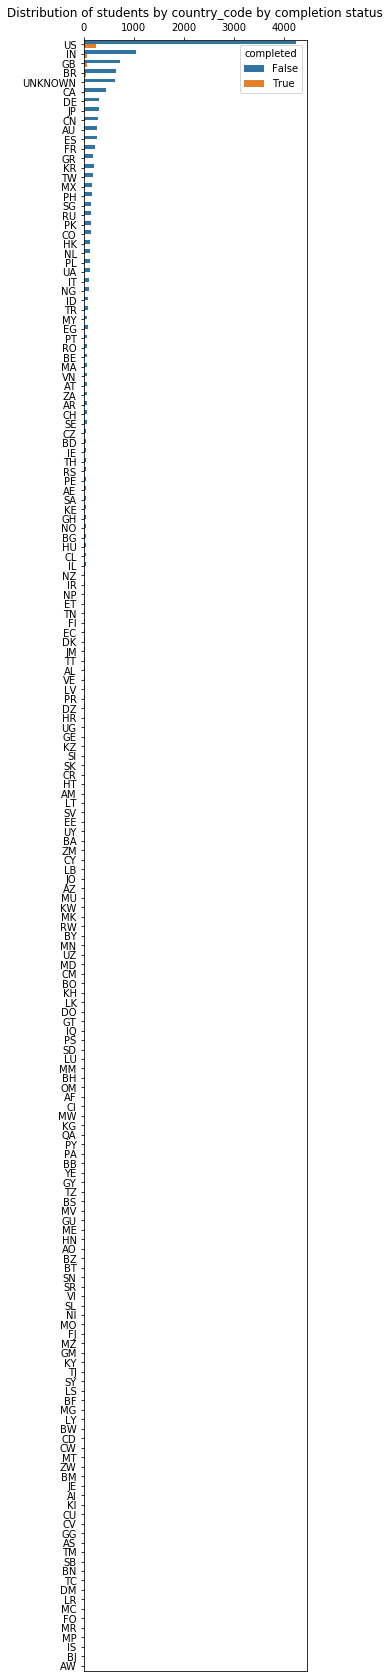

In [33]:


fig, ax = plt.subplots(figsize=(4, 30))
sns.countplot(y="country_code", 
            hue='completed', 
           order=df_feats.groupby('country_code').country_code.count().sort_values(ascending=False).index,
            data=df_feats, 
            ax=ax)
ax.set_title("Distribution of students by country_code by completion status")
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('')
ax.set_ylabel('')

plt.show()
plt.close()



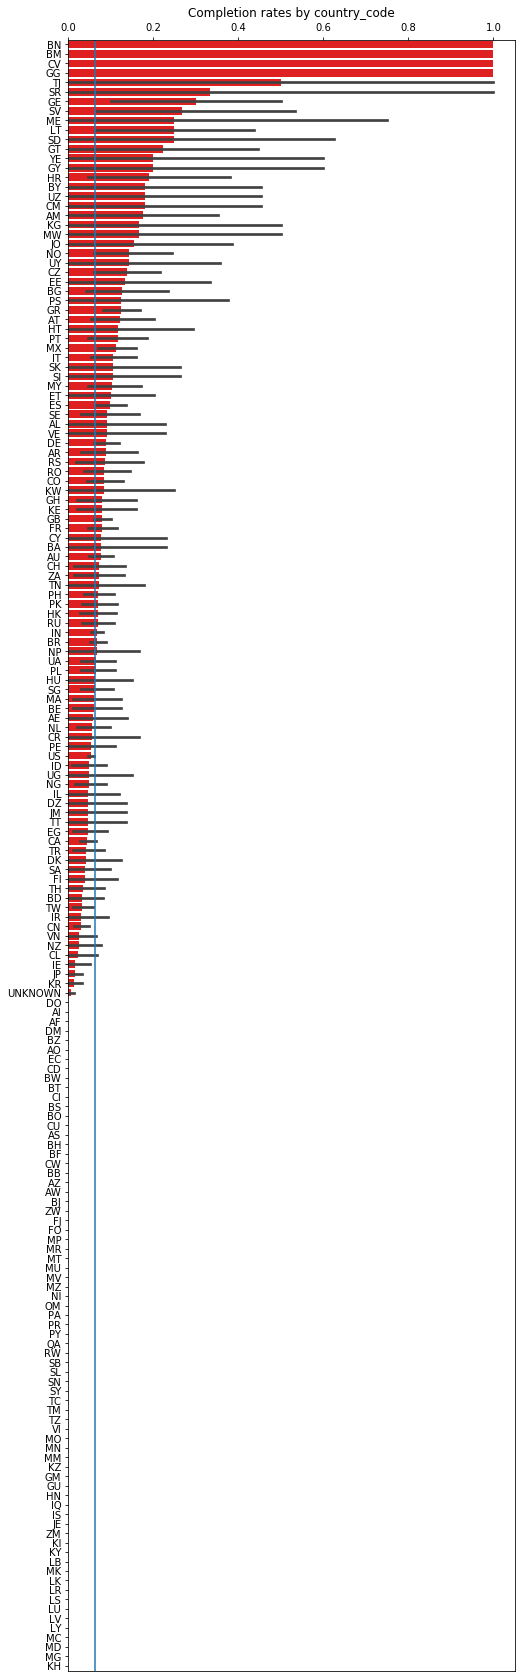

In [34]:
fig, ax = plt.subplots(figsize=(8, 30))
sns.barplot(y="country_code", 
            x='completed', 
            order=df_feats.groupby('country_code').completed.mean().sort_values(ascending=False).index,
            data=df_feats, 
            color='red',
            ax=ax)

ax.set_title('Completion rates by country_code')
ax.axvline(x=df_er22x.completed.mean())
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('')
ax.set_ylabel('')

plt.show()
plt.close()


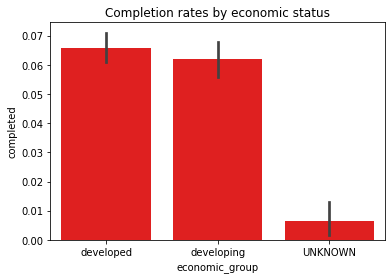

In [35]:
fig, ax = plt.subplots()
sns.barplot(x="economic_group", 
            y='completed', 
            order=df_feats.groupby('economic_group').completed.mean().sort_values(ascending=False).index,
            data=df_feats, 
            color='red',
            ax=ax)

ax.set_title("Completion rates by economic status")

plt.show()
plt.close()

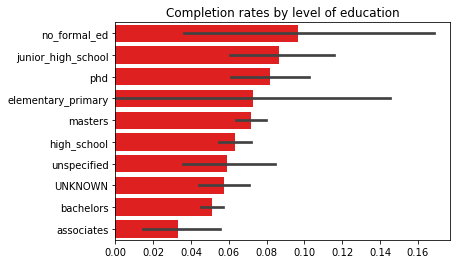

In [36]:
fig, ax = plt.subplots()
sns.barplot(y="level_of_education", 
            x='completed', 
            order=df_feats.groupby('level_of_education').completed.mean().sort_values(ascending=False).index,
            data=df_feats, 
            color='red',
            ax=ax)

ax.set_title('Completion rates by level of education')

ax.set_xlabel('')
ax.set_ylabel('')

plt.show()
plt.close()

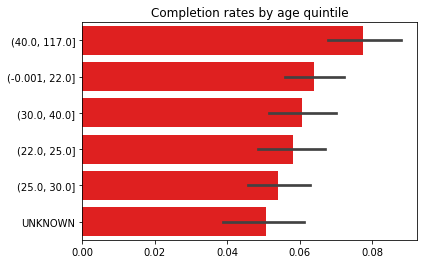

In [37]:
fig, ax = plt.subplots()
sns.barplot(y="age", 
            x='completed', 
            order=df_feats.groupby('age').completed.mean().sort_values(ascending=False).index,
            data=df_feats, 
            color='red',
            ax=ax)

ax.set_title('Completion rates by age quintile')

ax.set_xlabel('')
ax.set_ylabel('')

plt.show()
plt.close()

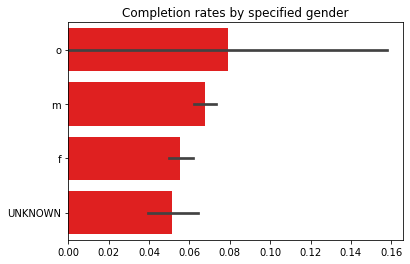

In [38]:
fig, ax = plt.subplots()
sns.barplot(y="gender", 
            x='completed', 
            order=df_feats.groupby('gender').completed.mean().sort_values(ascending=False).index,
            data=df_feats, 
            color='red',
            ax=ax)

ax.set_title('Completion rates by specified gender')
ax.set_xlabel('')
ax.set_ylabel('')

plt.show()
plt.close()

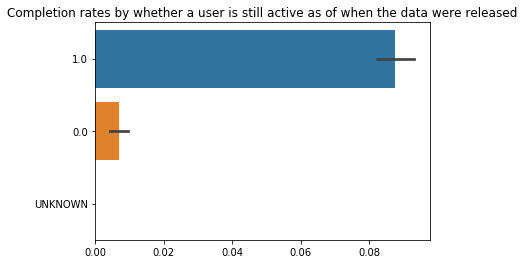

In [39]:
fig, ax = plt.subplots()
sns.barplot(y="still_active", 
            x='completed', 
            order=df_feats.groupby('still_active').completed.mean().sort_values(ascending=False).index,
            data=df_feats, 
            ax=ax)

ax.set_title('Completion rates by whether a user is still active as of when the data were released')
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()
plt.close()

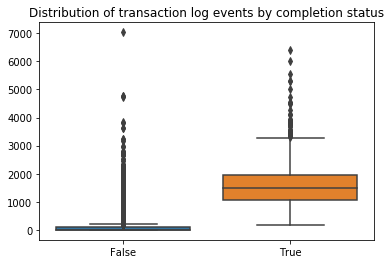

In [40]:
fig, ax = plt.subplots()
sns.boxplot(y="num_log_events", 
            x='completed', 
            data=df_feats, 
            ax=ax)

ax.set_title('Distribution of transaction log events by completion status')

ax.set_xlabel('')
ax.set_ylabel('')

plt.show()
plt.close()

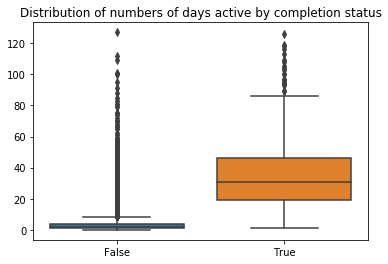

In [41]:
fig, ax = plt.subplots()
sns.boxplot(y="num_days_active", 
            x='completed', 
            data=df_feats, 
            ax=ax)

ax.set_title('Distribution of numbers of days active by completion status')

ax.set_xlabel('')
ax.set_ylabel('')

plt.show()

plt.close()

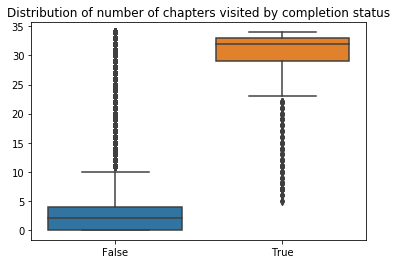

In [45]:
fig, ax = plt.subplots()
sns.boxplot(y="num_chapters_visited", 
            x='completed', 
            data=df_feats, 
            ax=ax)

ax.set_title('Distribution of number of chapters visited by completion status')

ax.set_xlabel('')
ax.set_ylabel('')

plt.show()
plt.close()

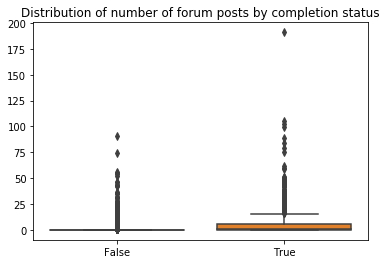

In [46]:
fig, ax = plt.subplots()
sns.boxplot(y="num_forum_posts", 
            x='completed', 
            data=df_feats, 
            ax=ax)

ax.set_title('Distribution of number of forum posts by completion status')

ax.set_xlabel('')
ax.set_ylabel('')

plt.show()
plt.close()

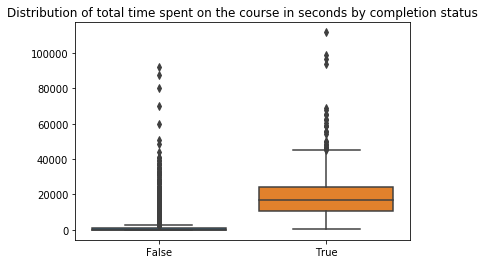

In [47]:
fig, ax = plt.subplots()
sns.boxplot(y="total_time_seconds", 
            x='completed', 
            data=df_feats, 
            ax=ax)

ax.set_title('Distribution of total time spent on the course in seconds by completion status')

ax.set_xlabel('')
ax.set_ylabel('')

plt.show()
plt.close()

In [49]:
df_target = df_feats[target].astype(int)
df_numeric_feats = df_feats[numeric_feats]
df_categorical_feats = df_feats[categorical_feats]


The charts above suggest that there is some signal:

Students who pass the course tend to:

* spend more time on the course
* post more
* engage more with the course material (more chapters visited)
* be more active in general (more log events)
* still engage with edx 
* be male 
* tend to be older (retired folks with more time on their hands?)
* tend to be from developed countries (though the difference is within the margin of error)
* tend to be middle schoolers (prodigies?) or PhDs 



### Modeling

In our modeling and experiments, we use random forests and gradient boosted machines are our black box models. Ensembles of decision trees tend to work well with mixed numerical and categorical data without much tuning. 

We assess our models using test set accuracy and class-wise precision and recall.

Precision is the fraction of cases where the model predicted a particular class and was correct.

Recall is the fraction of cases present in the evaluation set for a particular class that were predicted correctly by the model.

The f1 score is the harmonic mean of precision and recall.

<img src="./img/prec_recall.png">



We first encode the categorical features as one-hots.

In [50]:
df_one_hots = pd.get_dummies(df_categorical_feats)

df_one_hots = df_one_hots[[c for c in df_one_hots.columns if not 'UNKNOWN' in c]]
df_one_hots.head()

,country_code_AE,country_code_AF,country_code_AI,country_code_AL,country_code_AM,country_code_AO,country_code_AR,country_code_AS,country_code_AT,country_code_AU,...,"age_(-0.001, 22.0]","age_(22.0, 25.0]","age_(25.0, 30.0]","age_(30.0, 40.0]","age_(40.0, 117.0]",gender_f,gender_m,gender_o,still_active_0.0,still_active_1.0
287750,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
287751,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
287752,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
287753,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
287754,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Original

In [29]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

def make_rf(df_numeric_feats, df_one_hots, df_target):
    X_df = pd.concat((df_numeric_feats, df_one_hots), axis=1)
    y =  df_target.values

    X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

    # guesses a class uniformly as random
    unif_dummy = DummyClassifier(strategy='uniform')

    # always guesses the majority class
    most_frequent_dummy = DummyClassifier(strategy='most_frequent')

    unif_dummy.fit(X_train, y_train)
    most_frequent_dummy.fit(X_train, y_train)


    rf = RandomForestClassifier(n_estimators=100, 
                           criterion='gini', 
                           max_depth=None, 
                           min_samples_split=2, 
                           min_samples_leaf=1, 
                           min_weight_fraction_leaf=0.0, 
                           max_features='auto', 
                           max_leaf_nodes=None, 
                           min_impurity_decrease=0.0, 
                           min_impurity_split=None, 
                           bootstrap=True, 
                           oob_score=True, 
                           n_jobs=None, 
                           random_state=42, 
                           verbose=0, 
                           warm_start=False, 
                           class_weight=None, 
                           ccp_alpha=0.0, 
                           max_samples=None)

    rf.fit(X_train, y_train)

    y_pred_test_rf = rf.predict(X_test)
    y_pred_test_unif = unif_dummy.predict(X_test)
    y_pred_test_mf = most_frequent_dummy.predict(X_test)

    print(f"RF OOB score: {100*rf.oob_score_:.4f}%")
    print(f"RF Test Set Accuracy: {100*accuracy_score(y_test, y_pred_test_rf):.4f}%")
    print("RF Test Set Classification Report:")
    print(classification_report(y_test, y_pred_test_rf))

    print(f"Unif Dummy Test Set Accuracy: {100*accuracy_score(y_test, y_pred_test_unif):.4f}%")
    print("Unif Dummy Test Set Classification Report:")
    print(classification_report(y_test, y_pred_test_unif))

    print(f"Most Freq Dummy Test Set Accuracy: {100*accuracy_score(y_test, y_pred_test_mf):.4f}%")
    print("Most Freq Dummy Test Set Classification Report:")
    print(classification_report(y_test, y_pred_test_mf))
    
    return rf, X_test, y_test, X_train, y_train

df_target = df_feats[target].astype(int)
df_numeric_feats = df_feats[numeric_feats]
df_categorical_feats = df_feats[categorical_feats]

df_one_hots = pd.get_dummies(df_categorical_feats)

df_one_hots = df_one_hots[[c for c in df_one_hots.columns if not 'UNKNOWN' in c]]

rf_orig, X_test_orig, y_test_orig, X_train_orig, y_train_orig = make_rf(df_numeric_feats, df_one_hots, df_target)

RF OOB score: 97.7915%
RF Test Set Accuracy: 97.8571%
RF Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2884
           1       0.85      0.80      0.83       196

    accuracy                           0.98      3080
   macro avg       0.92      0.90      0.91      3080
weighted avg       0.98      0.98      0.98      3080

Unif Dummy Test Set Accuracy: 49.7727%
Unif Dummy Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.50      0.65      2884
           1       0.07      0.52      0.12       196

    accuracy                           0.50      3080
   macro avg       0.50      0.51      0.38      3080
weighted avg       0.88      0.50      0.62      3080

Most Freq Dummy Test Set Accuracy: 93.6364%
Most Freq Dummy Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.94     

/Users/michaeldowns/miniconda3/envs/ac221/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The RF classifier outperforms the two naive classifiers on all fronts which suggests that it learned something nontrivial. This corroborates our hypothesis that there is signal among the feature set.

We note that the baseline accuracy is around 94%.

We do not have to perform class balancing

#### 5-anonymous: Suppression

In [52]:
def check_still_has_unknowns(df):
    print(categorical_feats)
    for feature in categorical_feats:
        s = df[feature]
        
        if (s == 'UNKNOWN').any():
            print(f"{feature} has an unknown value.")
            
check_still_has_unknowns(df_5a_sup)

['country_code', 'economic_group', 'level_of_education', 'age', 'gender', 'still_active']
country_code has an unknown value.
economic_group has an unknown value.
level_of_education has an unknown value.
age has an unknown value.
gender has an unknown value.
still_active has an unknown value.


In [53]:
df_target = df_5a_sup[target].astype(int)
df_numeric_feats = df_5a_sup[numeric_feats]
df_categorical_feats = df_5a_sup[categorical_feats]

df_one_hots = pd.get_dummies(df_categorical_feats)

df_one_hots = df_one_hots[[c for c in df_one_hots.columns if not 'UNKNOWN' in c]]

rf_5a_sup, X_test_5a_sup, y_test_5a_sup, X_train_5a_sup, y_train_5a_sup  = make_rf(df_numeric_feats, df_one_hots, df_target)

RF OOB score: 98.6400%
RF Test Set Accuracy: 98.5163%
RF Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1953
           1       0.82      0.72      0.77        69

    accuracy                           0.99      2022
   macro avg       0.90      0.86      0.88      2022
weighted avg       0.98      0.99      0.98      2022

Unif Dummy Test Set Accuracy: 51.9782%
Unif Dummy Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.52      0.68      1953
           1       0.03      0.48      0.06        69

    accuracy                           0.52      2022
   macro avg       0.50      0.50      0.37      2022
weighted avg       0.93      0.52      0.66      2022

Most Freq Dummy Test Set Accuracy: 96.5875%
Most Freq Dummy Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.97     

/Users/michaeldowns/miniconda3/envs/ac221/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The random forest classifier still outperforms the naive baselines, but the gap has shrunk. 

#### 5-anonymous: Synthetic Record Generation

In [54]:
df_target = df_5a_syn[target].astype(int)
df_numeric_feats = df_5a_syn[numeric_feats]
df_categorical_feats = df_5a_syn[categorical_feats]

df_one_hots = pd.get_dummies(df_categorical_feats)

df_one_hots = df_one_hots[[c for c in df_one_hots.columns if not 'UNKNOWN' in c]]

rf_5a_syn, X_test_5a_syn, y_test_5a_syn, X_train_5a_syn, y_train_5a_syn = make_rf(df_numeric_feats, df_one_hots, df_target)

RF OOB score: 97.8948%
RF Test Set Accuracy: 97.9342%
RF Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5345
           1       0.85      0.82      0.84       367

    accuracy                           0.98      5712
   macro avg       0.92      0.91      0.91      5712
weighted avg       0.98      0.98      0.98      5712

Unif Dummy Test Set Accuracy: 50.4552%
Unif Dummy Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.50      0.66      5345
           1       0.07      0.53      0.12       367

    accuracy                           0.50      5712
   macro avg       0.50      0.51      0.39      5712
weighted avg       0.88      0.50      0.62      5712

Most Freq Dummy Test Set Accuracy: 93.5749%
Most Freq Dummy Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.94     

/Users/michaeldowns/miniconda3/envs/ac221/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The synthetic records did not affect the model's performance.

#### 5-anonymous: Synthetic Record Generation (alternate)

In [40]:
df_target = df_5a_syn_alt[target].astype(int)
df_numeric_feats = df_5a_syn_alt[numeric_feats]
df_categorical_feats = df_5a_syn_alt[categorical_feats]

df_one_hots = pd.get_dummies(df_categorical_feats)

df_one_hots = df_one_hots[[c for c in df_one_hots.columns if not 'UNKNOWN' in c]]

rf_5a_syn_alt, X_test_5a_syn_alt, y_test_5a_syn_alt, X_train_5a_syn_alt, y_train_5a_syn_alt = make_rf(df_numeric_feats, df_one_hots, df_target)

RF OOB score: 92.8571%
RF Test Set Accuracy: 92.7696%
RF Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5123
           1       0.77      0.42      0.55       589

    accuracy                           0.93      5712
   macro avg       0.85      0.71      0.75      5712
weighted avg       0.92      0.93      0.92      5712

Unif Dummy Test Set Accuracy: 49.6674%
Unif Dummy Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.50      0.64      5123
           1       0.10      0.49      0.17       589

    accuracy                           0.50      5712
   macro avg       0.50      0.49      0.40      5712
weighted avg       0.81      0.50      0.59      5712

Most Freq Dummy Test Set Accuracy: 89.6884%
Most Freq Dummy Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.90     

/Users/michaeldowns/miniconda3/envs/ac221/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The random forest classifier still outperforms the naive baseline in this case, but has inferior precision and recalls for the positive class as the relationship between the most predictive features and the target was partially broken.

### 5-anonymous: Blurring and Generalization

In [56]:
numeric_feats_bg = list(set(numeric_feats) - set(best_cols))
categorical_feats_bg = list(set(categorical_feats) - set(best_cols))

df_target = df_blurred_generalized[target].astype(int)
df_numeric_feats = df_blurred_generalized[numeric_feats_bg]
df_categorical_feats = df_blurred_generalized[categorical_feats_bg]

df_one_hots = pd.get_dummies(df_categorical_feats)

df_one_hots = df_one_hots[[c for c in df_one_hots.columns if not 'UNKNOWN' in c]]

rf_5a_blurred_generalized, X_test_5a_blurred_generalized, y_test_5a_blurred_generalized, X_train_5a_blurred_generalized, y_train_5a_blurred_generalized = make_rf(df_numeric_feats, 
                                                                                            df_one_hots, 
                                                                                            df_target)



RF OOB score: 97.8233%
RF Test Set Accuracy: 97.8889%
RF Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2895
           1       0.84      0.80      0.82       184

    accuracy                           0.98      3079
   macro avg       0.91      0.89      0.90      3079
weighted avg       0.98      0.98      0.98      3079

Unif Dummy Test Set Accuracy: 50.8931%
Unif Dummy Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.51      0.66      2895
           1       0.06      0.49      0.11       184

    accuracy                           0.51      3079
   macro avg       0.50      0.50      0.38      3079
weighted avg       0.89      0.51      0.63      3079

Most Freq Dummy Test Set Accuracy: 94.0240%
Most Freq Dummy Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.94     

/Users/michaeldowns/miniconda3/envs/ac221/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The random forest still performs well which suggests that the blurred and generalized features were not important.

### Alternate Imputation

In [30]:
numeric_feats = ['num_chapters_visited',
 'num_log_events',
 'total_time_seconds',
 'num_days_active',
                 'num_forum_posts'
    ]

In [31]:
df_target = df_feats_alt_imp[target].astype(int)
df_numeric_feats = df_feats_alt_imp[numeric_feats]
df_categorical_feats = df_feats_alt_imp[categorical_feats]

df_one_hots = pd.get_dummies(df_categorical_feats, drop_first=True)

rf_feats_alt_imp, X_test_feats_alt_imp, y_test_feats_alt_imp, X_train_feats_alt_imp, y_train_feats_alt_imp = make_rf(df_numeric_feats, df_one_hots, df_target)



RF OOB score: 97.6047%
RF Test Set Accuracy: 97.5325%
RF Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2884
           1       0.82      0.78      0.80       196

    accuracy                           0.98      3080
   macro avg       0.90      0.88      0.89      3080
weighted avg       0.97      0.98      0.98      3080

Unif Dummy Test Set Accuracy: 51.5260%
Unif Dummy Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.52      0.67      2884
           1       0.06      0.44      0.10       196

    accuracy                           0.52      3080
   macro avg       0.50      0.48      0.39      3080
weighted avg       0.88      0.52      0.63      3080

Most Freq Dummy Test Set Accuracy: 93.6364%
Most Freq Dummy Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.94     

/Users/michaeldowns/miniconda3/envs/ac221/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The classifier still performs better than the baseline even with this inferior imputation strategy.

### Random Duplicates



In [32]:
df_target = df_feats_duplicates[target].astype(int)
df_numeric_feats = df_feats_duplicates[numeric_feats]
df_categorical_feats = df_feats_duplicates[categorical_feats]

df_one_hots = pd.get_dummies(df_categorical_feats)

df_one_hots = df_one_hots[[c for c in df_one_hots.columns if not 'UNKNOWN' in c]]

rf_feats_duplicates, X_test_feats_duplicates, y_test_feats_duplicates, X_train_feats_duplicates, y_train_feats_duplicates = make_rf(df_numeric_feats, 
                                                                                            df_one_hots, 
                                                                                            df_target)


RF OOB score: 99.8250%
RF Test Set Accuracy: 99.8800%
RF Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9360
           1       0.99      0.99      0.99       640

    accuracy                           1.00     10000
   macro avg       1.00      0.99      0.99     10000
weighted avg       1.00      1.00      1.00     10000

Unif Dummy Test Set Accuracy: 49.3400%
Unif Dummy Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.49      0.65      9360
           1       0.06      0.50      0.11       640

    accuracy                           0.49     10000
   macro avg       0.50      0.50      0.38     10000
weighted avg       0.88      0.49      0.61     10000

Most Freq Dummy Test Set Accuracy: 93.6000%
Most Freq Dummy Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.94     

/Users/michaeldowns/miniconda3/envs/ac221/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The random forest performs better in this case because records that are in the training set are now likely in the test set as well due to the random segmentation of the data.

### Systematic Duplicates 

In [33]:
df_target = df_feats_duplicates_sys[target].astype(int)
df_numeric_feats = df_feats_duplicates_sys[numeric_feats]
df_categorical_feats = df_feats_duplicates_sys[categorical_feats]

df_one_hots = pd.get_dummies(df_categorical_feats)

df_one_hots = df_one_hots[[c for c in df_one_hots.columns if not 'UNKNOWN' in c]]

rf_feats_duplicates_sys, X_test_feats_duplicates_sys, y_test_feats_duplicates_sys, X_train_feats_duplicates_sys, y_train_feats_duplicates_sys = make_rf(df_numeric_feats, 
                                                                                            df_one_hots, 
                                                                                            df_target)


RF OOB score: 99.4225%
RF Test Set Accuracy: 99.4700%
RF Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9802
           1       1.00      0.73      0.85       198

    accuracy                           0.99     10000
   macro avg       1.00      0.87      0.92     10000
weighted avg       0.99      0.99      0.99     10000

Unif Dummy Test Set Accuracy: 50.7300%
Unif Dummy Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.51      0.67      9802
           1       0.02      0.52      0.04       198

    accuracy                           0.51     10000
   macro avg       0.50      0.51      0.35     10000
weighted avg       0.96      0.51      0.66     10000

Most Freq Dummy Test Set Accuracy: 98.0200%
Most Freq Dummy Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98     

/Users/michaeldowns/miniconda3/envs/ac221/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The classifier has a lower recall for cases where the users passed the class, but still outperforms the baseline. It also has higher accuracy for the same reasons as in the random duplicates case.

## Experiments


We now apply interpretability techniques to our random forest model trained with the original dataset and to the random forest models trained on the altered datasets. We compare the outputs of these techniques and discuss differences across datasets.

### Partial Dependence

Partial dependence analysis explains how varying a single feature ($x_s$) (or set of features) supplied to a model affects the model's output. The effects of other features not of interest ($x_c$) are controlled for by calculating the average output of the model as function of the feature of interest ($x_s$), when many levels of this feature are paired with all other sets of $x_c$s in the data. Mathematically this expectation is expressed as:


$$f(x_s) = E_{x_c}[f(x_s, x_c)] = \int f(x_s, x_c)dP(x_c)$$


where f is the model, and the integral is over sets of $x_c$ [1]. In the present case where we are modeling a categorical variable 'completed', a partial dependence plot displays changes in the probability of completing the course as the feature of interest varies (ref).

Partial dependence does have its drawbacks, however, and there are related techniques which address these shortcomings. See individual conditional expectation (ICE) and accumulated local effects (ALE) plots [1].

Here, partial dependency plots are presented for several features for the datasets listed below to examine what effect different methods of making the dataset 5 anonymous has on the model's dependence on these features:

* The original Dataset
* The original made 5 anonymous by supression
* The original made 5 anonymous by synthesis
* The original made 5 anonymous by synthesis alternative method



#### Calculations

*original data calculations*

In [49]:
from sklearn.inspection import partial_dependence

In [95]:
# Making subgroups to examine
num_group = ['num_log_events', 'num_days_active','num_chapters_visited', 
       'num_forum_posts', 'total_time_seconds']

eg_group = ['economic_group_developed','economic_group_developing']

loe_group = [ 'no_formal_ed','elementary_primary','junior_high_school','high_school',
       'associates','bachelors','masters','phd','unspecified']

age_group = ['age_(0, 22]', 'age_(22, 25]', 'age_(25, 30]', 
             'age_(30, 40]', 'age_(40, 117']

gen_group = ['female', 'male', 'other']

sa_group = ['not_still_active', 'still_active']

eg_group = ['developed','developing']

In [51]:
# function to calculate partial dependences from the EDX data
def calculate_partial_dependencies(rf, X, r_num, r_loe, r_eg, r_age, r_sa, r_gen):
        
    # Calculating partial dependencies num_group
    r = r_num
    pds_num = [] 
    pds_names_num = []
    for i, col in enumerate(num_group):
        pds_num.append(partial_dependence(rf, X, features=[r[i]]))
        #print(X.columns[r[i]], col)
        pds_names_num.append(col)

    # Calculating partial dependencies loe_group
    r = r_loe
    pds_loe = [] 
    pds_names_loe = []
    for i, col in enumerate(loe_group):
        pds_loe.append(partial_dependence(rf, X, features=[r[i]]))
        #print(X.columns[r[i]], col)
        pds_names_loe.append(col)

    # Calculating partial dependencies eg_group
    r = r_eg
    pds_eg = [] 
    pds_names_eg = []
    for i, col in enumerate(eg_group):
        pds_eg.append(partial_dependence(rf, X, features=[r[i]]))
        #print(X.columns[r[i]], col)
        pds_names_eg.append(col)

    # Calculating partial dependencies age_group
    r = r_age
    pds_age = [] 
    pds_names_age = []
    for i, col in enumerate(age_group):
        pds_age.append(partial_dependence(rf, X, features=[r[i]]))
        #print(X.columns[r[i]], col)
        pds_names_age.append(col)

    # Calculating partial dependencies sa_group
    r = r_sa
    pds_sa = [] 
    pds_names_sa = []
    for i, col in enumerate(sa_group):
        pds_sa.append(partial_dependence(rf, X, features=[r[i]]))
        #print(X.columns[r[i]], col)
        pds_names_sa.append(col)

    # Calculating partial dependencies gen_group
    r = r_gen
    pds_gen = [] 
    pds_names_gen = []
    for i, col in enumerate(gen_group):
        pds_gen.append(partial_dependence(rf, X, features=[r[i]]))
        #print(X.columns[r[i]], col)
        pds_names_gen.append(col)
        
    return  pds_num , pds_names_num , pds_loe ,  pds_names_loe , pds_eg  , \
    pds_names_eg , pds_age , pds_names_age , pds_sa ,  pds_names_sa , pds_gen , pds_names_gen

In [53]:
r_num = [0, 1, 2, 3, 4]
r_loe = [184, 180, 182, 181, 178, 179, 183, 185, 186]
r_eg = [176, 177]
r_age = [187, 188, 189, 190, 191]
r_sa = [195, 196]
r_gen = [192, 193, 194]

In [204]:
# Calculating partial dependencies
pds_num_orig, pds_names_num_orig , pds_loe_orig, \
pds_names_loe_orig, pds_eg_orig, pds_names_eg_orig ,pds_age_orig , pds_names_age_orig,\
pds_sa_orig, pds_names_sa_orig , pds_gen_orig, \
pds_names_gen_orig  = calculate_partial_dependencies(rf_orig, X_test_orig, r_num, r_loe, r_eg, r_age, r_sa, r_gen)

*5-anonymous: Suppression calculations*

In [93]:
# Making subgroups 
loe_group = ['elementary_primary','junior_high_school','high_school',
       'associates','bachelors','masters','phd','unspecified']


gen_group = ['female', 'male']

In [56]:
r_num = [0, 1, 2, 3, 4]
r_loe = [65, 67, 66, 63, 64, 68, 69, 70]
r_eg = [61, 62]
r_age = list(range(71,76))
r_sa = [78, 79]
r_gen = [76, 77]

In [57]:
# Calculating partial dependencies
pds_num_5a_sup, pds_names_num_5a_sup , pds_loe_5a_sup, \
pds_names_loe_5a_sup, pds_eg_5a_sup, pds_names_eg_5a_sup ,pds_age_5a_sup , pds_names_age_5a_sup,\
pds_sa_5a_sup, pds_names_sa_5a_sup , pds_gen_5a_sup, \
pds_names_gen_5a_sup  = calculate_partial_dependencies(rf_5a_sup, X_test_5a_sup, r_num, r_loe, r_eg, r_age, r_sa, r_gen)

*5-anonymous: Synthetic Record Generation calculations*

In [96]:
# Making subgroups to examine
loe_group = [ 'no_formal_ed','elementary_primary','junior_high_school','high_school',
       'associates','bachelors','masters','phd','unspecified']

gen_group = ['female', 'male', 'other']

In [97]:
r_num = [0, 1, 2, 3, 4]
r_loe = [184, 180, 182, 181, 178, 179, 183, 185, 186]
r_eg = [176, 177]
r_age = [187, 188, 189, 190, 191]
r_sa = [195, 196]
r_gen = [192, 193, 194]

In [60]:
# Calculating partial dependencies
pds_num_5a_syn, pds_names_num_5a_syn , pds_loe_5a_syn, \
pds_names_loe_5a_syn, pds_eg_5a_syn, pds_names_eg_5a_syn ,pds_age_5a_syn , pds_names_age_5a_syn,\
pds_sa_5a_syn, pds_names_sa_5a_syn , pds_gen_5a_syn, \
pds_names_gen_5a_syn  = calculate_partial_dependencies(rf_5a_syn, X_test_5a_syn, r_num, r_loe, r_eg, r_age, r_sa, r_gen)

*5-anonymous: Synthetic Record Generation (alternate) calculations*

In [61]:
# Calculating partial dependencies
pds_num_5a_syn_alt, pds_names_num_5a_syn_alt , pds_loe_5a_syn_alt, \
pds_names_loe_5a_syn_alt, pds_eg_5a_syn_alt, pds_names_eg_5a_syn_alt ,pds_age_5a_syn_alt , pds_names_age_5a_syn_alt,\
pds_sa_5a_syn_alt, pds_names_sa_5a_syn_alt , pds_gen_5a_syn_alt, \
pds_names_gen_5a_syn_alt  = calculate_partial_dependencies(rf_5a_syn_alt, X_test_5a_syn_alt, r_num, r_loe, r_eg, r_age, r_sa, r_gen)

#### Combined Partial Dependency Plots for Numeric Features

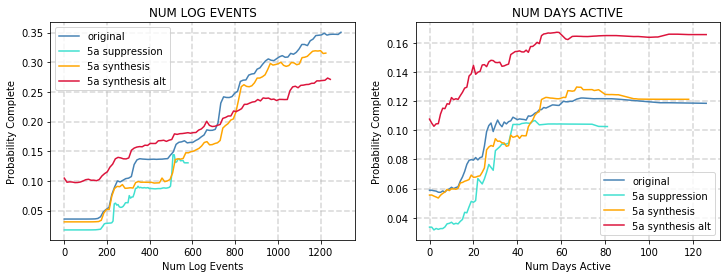

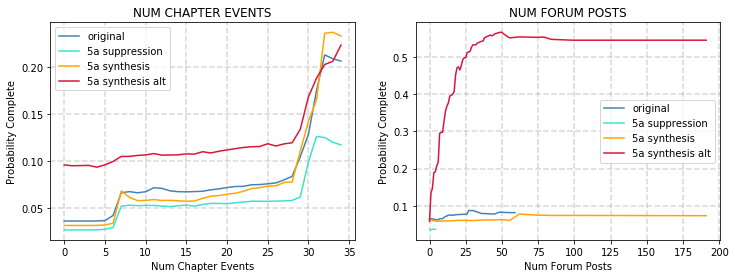

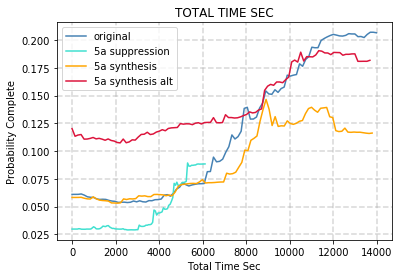

In [207]:
plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
plt.plot(pds_num_orig[0][1][0], pds_num_orig[0][0][0], c = 'steelblue', label = 'original')
plt.plot(pds_num_5a_sup[0][1][0], pds_num_5a_sup[0][0][0], c = 'turquoise', label = '5a suppression')
plt.plot(pds_num_5a_syn[0][1][0], pds_num_5a_syn[0][0][0], c = 'orange', label = '5a synthesis')
plt.plot(pds_num_5a_syn_alt[0][1][0], pds_num_5a_syn_alt[0][0][0], c = 'crimson', label = '5a synthesis alt')
plt.xlabel('Num Log Events')
plt.ylabel('Probability Complete')
plt.grid(True, lw=1.5, ls='--', alpha=0.5)
plt.legend()
plt.title('Num Log Events'.upper())

plt.subplot(1,2,2)
plt.plot(pds_num_orig[1][1][0], pds_num_orig[1][0][0], c = 'steelblue', label = 'original')
plt.plot(pds_num_5a_sup[1][1][0], pds_num_5a_sup[1][0][0], c = 'turquoise', label = '5a suppression')
plt.plot(pds_num_5a_syn[1][1][0], pds_num_5a_syn[1][0][0], c = 'orange', label = '5a synthesis')
plt.plot(pds_num_5a_syn_alt[1][1][0], pds_num_5a_syn_alt[1][0][0], c = 'crimson', label = '5a synthesis alt')
plt.xlabel('Num Days Active')
plt.ylabel('Probability Complete')
plt.grid(True, lw=1.5, ls='--', alpha=0.5)
plt.legend()
plt.title('Num Days Active'.upper())
plt.show()

plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
plt.plot(pds_num_orig[2][1][0], pds_num_orig[2][0][0], c = 'steelblue', label = 'original')
plt.plot(pds_num_5a_sup[2][1][0], pds_num_5a_sup[2][0][0], c = 'turquoise', label = '5a suppression')
plt.plot(pds_num_5a_syn[2][1][0], pds_num_5a_syn[2][0][0], c = 'orange', label = '5a synthesis')
plt.plot(pds_num_5a_syn_alt[2][1][0], pds_num_5a_syn_alt[2][0][0], c = 'crimson', label = '5a synthesis alt')
plt.xlabel('Num Chapter Events')
plt.ylabel('Probability Complete')
plt.grid(True, lw=1.5, ls='--', alpha=0.5)
plt.legend()
plt.title('Num Chapter Events'.upper())

plt.subplot(1,2,2)
plt.plot(pds_num_orig[3][1][0], pds_num_orig[3][0][0], c = 'steelblue', label = 'original')
plt.plot(pds_num_5a_sup[3][1][0], pds_num_5a_sup[3][0][0], c = 'turquoise', label = '5a suppression')
plt.plot(pds_num_5a_syn[3][1][0], pds_num_5a_syn[3][0][0], c = 'orange', label = '5a synthesis')
plt.plot(pds_num_5a_syn_alt[3][1][0], pds_num_5a_syn_alt[3][0][0], c = 'crimson', label = '5a synthesis alt')
plt.xlabel('Num Forum Posts')
plt.ylabel('Probability Complete')
plt.grid(True, lw=1.5, ls='--', alpha=0.5)
plt.legend()
plt.title('Num Forum Posts'.upper())
plt.show()

plt.figure(figsize = (6, 4))
plt.subplot(1,1,1)
plt.plot(pds_num_orig[4][1][0], pds_num_orig[4][0][0], c = 'steelblue', label = 'original')
plt.plot(pds_num_5a_sup[4][1][0], pds_num_5a_sup[4][0][0], c = 'turquoise', label = '5a suppression')
plt.plot(pds_num_5a_syn[4][1][0], pds_num_5a_syn[4][0][0], c = 'orange', label = '5a synthesis')
plt.plot(pds_num_5a_syn_alt[4][1][0], pds_num_5a_syn_alt[4][0][0], c = 'crimson', label = '5a synthesis alt')
plt.xlabel('Total Time Sec')
plt.ylabel('Probability Complete')
plt.grid(True, lw=1.5, ls='--', alpha=0.5)
plt.legend()
plt.title('Total Time Sec'.upper())
plt.show()

#### Comments
Looking at these plots, it is clear that altering the dataset to make it 5 anonymous has effects on the partial dependencies of these numeric features. While the trends remain the same, the partcular shapes of the functions vary, and what is most evident is that using the alternative synthetic method greatly perturbs these curves, often substantially increasing the model's dependence on each numeric feature.

#### Combined Partial Dependency Plots for Categorical Features

In [99]:
# function to get categorical dependicies
def get_cat_dependencies(deps, deps_names, category):
    dif = []
    names = []
    for i, item in enumerate(deps):
        dif.append(item[0][0][1] - item[0][0][0])
        names.append(deps_names[i])
    
    return dif, names, category

In [100]:
# Get dependancies
diff_age_orig, diff_names_age_orig, cat_age_orig\
= get_cat_dependencies(pds_age_orig, pds_names_age_orig, 'Age')

diff_age_5a_sup, diff_names_age_5a_sup, cat_age_5a_sup\
= get_cat_dependencies(pds_age_5a_sup, pds_names_age_5a_sup, 'Age')

diff_age_5a_syn, diff_names_age_5a_syn, cat_age_5a_syn\
= get_cat_dependencies(pds_age_5a_syn, pds_names_age_5a_syn, 'Age')

diff_age_5a_syn_alt, diff_names_age_5a_syn_alt, cat_age_5a_syn_alt\
= get_cat_dependencies(pds_age_5a_syn_alt, pds_names_age_5a_syn_alt, 'Age')

diff_gen_orig, diff_names_gen_orig, cat_gen_orig\
= get_cat_dependencies(pds_gen_orig, pds_names_gen_orig, 'gen')

diff_gen_5a_sup, diff_names_gen_5a_sup, cat_gen_5a_sup\
= get_cat_dependencies(pds_gen_5a_sup, pds_names_gen_5a_sup, 'gen')

diff_gen_5a_syn, diff_names_gen_5a_syn, cat_gen_5a_syn\
= get_cat_dependencies(pds_gen_5a_syn, pds_names_gen_5a_syn, 'gen')

diff_gen_5a_syn_alt, diff_names_gen_5a_syn_alt, cat_gen_5a_syn_alt\
= get_cat_dependencies(pds_gen_5a_syn_alt, pds_names_gen_5a_syn_alt, 'gen')

diff_loe_orig, diff_names_loe_orig, cat_loe_orig\
= get_cat_dependencies(pds_loe_orig, pds_names_loe_orig, 'loe')

diff_loe_5a_sup, diff_names_loe_5a_sup, cat_loe_5a_sup\
= get_cat_dependencies(pds_loe_5a_sup, pds_names_loe_5a_sup, 'loe')

diff_loe_5a_syn, diff_names_loe_5a_syn, cat_loe_5a_syn\
= get_cat_dependencies(pds_loe_5a_syn, pds_names_loe_5a_syn, 'loe')

diff_loe_5a_syn_alt, diff_names_loe_5a_syn_alt, cat_loe_5a_syn_alt\
= get_cat_dependencies(pds_loe_5a_syn_alt, pds_names_loe_5a_syn_alt, 'loe')

diff_eg_orig, diff_names_eg_orig, cat_eg_orig\
= get_cat_dependencies(pds_eg_orig, pds_names_eg_orig, 'eg')

diff_eg_5a_sup, diff_names_eg_5a_sup, cat_eg_5a_sup\
= get_cat_dependencies(pds_eg_5a_sup, pds_names_eg_5a_sup, 'eg')

diff_eg_5a_syn, diff_names_eg_5a_syn, cat_eg_5a_syn\
= get_cat_dependencies(pds_eg_5a_syn, pds_names_eg_5a_syn, 'eg')

diff_eg_5a_syn_alt, diff_names_eg_5a_syn_alt, cat_eg_5a_syn_alt\
= get_cat_dependencies(pds_eg_5a_syn_alt, pds_names_eg_5a_syn_alt, 'eg')

diff_sa_orig, diff_names_sa_orig, cat_sa_orig\
= get_cat_dependencies(pds_sa_orig, pds_names_sa_orig, 'sa')

diff_sa_5a_sup, diff_names_sa_5a_sup, cat_sa_5a_sup\
= get_cat_dependencies(pds_sa_5a_sup, pds_names_sa_5a_sup, 'sa')

diff_sa_5a_syn, diff_names_sa_5a_syn, cat_sa_5a_syn\
= get_cat_dependencies(pds_sa_5a_syn, pds_names_sa_5a_syn, 'sa')

diff_sa_5a_syn_alt, diff_names_sa_5a_syn_alt, cat_sa_5a_syn_alt\
= get_cat_dependencies(pds_sa_5a_syn_alt, pds_names_sa_5a_syn_alt, 'sa')

In [206]:
# function to plot categorical dependicies
def plot_cat_dependencies(deps, deps_names, category, plot_size=(6,4)):
    dif = []
    names = []
    for i, item in enumerate(deps):
        try:
            dif.append(item[0][0][1] - item[0][0][0])
            names.append(deps_names[i])
        except:
            pass
        
    fig, ax = plt.subplots(1,1, figsize=plot_size)
    sns.barplot(x=dif, 
                y= names, 
                color='steelblue',
                ax=ax)

    title = 'Partial Dependency Plot ' + category
    ax.set_title(title)
    ax.set_xlabel('Effect on Probability of Completion')
    ax.set_ylabel('')
    ax.grid(True, lw=1.5, ls='--', alpha=0.5)
    plt.show()
    plt.close()

*Partial Dependency Plot Age*

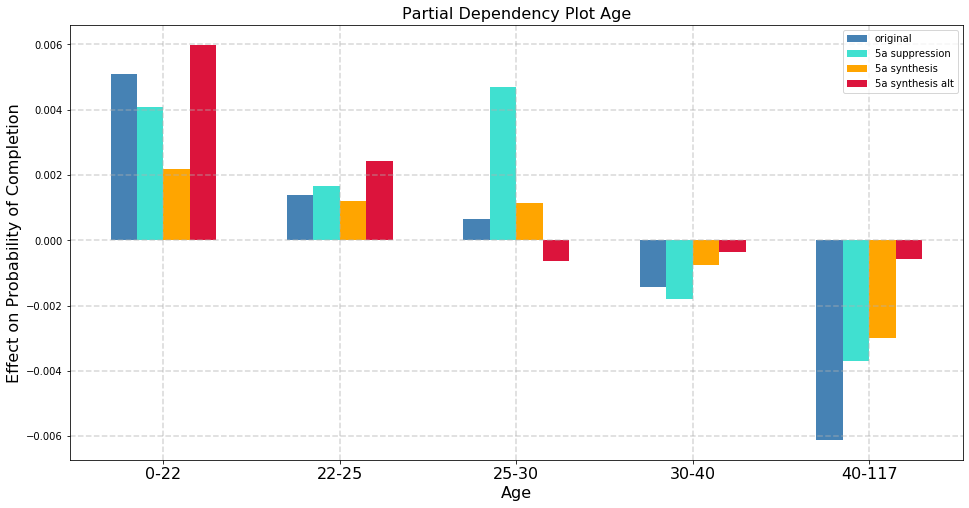

In [212]:
# plotting
import numpy as np
plt.figure(figsize = (16, 8))
N = 5
ind = np.arange(N) 
width = 0.15       
plt.bar(ind, diff_age_orig, width, label='original', color = 'steelblue')
plt.bar(ind + width, diff_age_5a_sup, width, label='5a suppression', color = 'turquoise')
plt.bar(ind + 2*width, diff_age_5a_syn, width, label='5a synthesis', color = 'orange')
plt.bar(ind + 3*width, diff_age_5a_syn_alt, width, label='5a synthesis alt', color = 'crimson')

title = 'Partial Dependency Plot Age'
plt.title(title, fontsize = 16)
plt.ylabel('Effect on Probability of Completion', fontsize='16')
plt.xlabel('Age',fontsize='16')
plt.grid(True, lw=1.5, ls='--', alpha=0.5)
plt.xticks(ind + 3*width / 2, ('0-22', '22-25', '25-30', '30-40', '40-117'), fontsize='16')
plt.legend(loc='best')
plt.show()

#### Comment
Here, looking at the effect of age on the probability of completing the course, we see that the younger ages have a positive effect, and the older a negative effect. More interesting, there are substantial differences in the size of the age effect across datasets. At age 25-30 for example, being in this age group has a positive effect in the original dataset, a much larger positive effect in the 5a synthetic dataset, and in fact a negative effect in the 5a syn alt dataset. We note that the effect size of age is small in general.

*Partial Dependency Plot Gender*

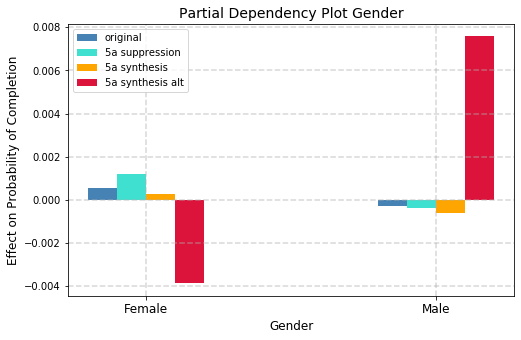

In [211]:
plt.figure(figsize = (8, 5))
N = 2
ind = np.arange(N) 
width = 0.1      
plt.bar(ind, diff_gen_orig[:2], width, label='original', color = 'steelblue')
plt.bar(ind + width, diff_gen_5a_sup, width, label='5a suppression', color = 'turquoise')
plt.bar(ind + 2*width, diff_gen_5a_syn[:2], width, label='5a synthesis', color = 'orange')
plt.bar(ind + 3*width, diff_gen_5a_syn_alt[:2], width, label='5a synthesis alt', color = 'crimson')

title = 'Partial Dependency Plot Gender'
plt.title(title, fontsize = 14)
plt.ylabel('Effect on Probability of Completion', fontsize='12')
plt.xlabel('Gender',fontsize='12')
plt.grid(True, lw=1.5, ls='--', alpha=0.5)
plt.xticks(ind +3*width/2, ('Female', 'Male'), fontsize='12')
plt.legend(loc='best')
plt.show()

#### Comment
Here, looking at the effect of gender on the probability of completing the course, we see that the in the original dataset being female has a positive effect relative to male, but again this effect varies across datasets and switches direction for the 5a syn alt dataset. Though the effect size is small, we comment that the dataset with improperly generated synthetic records inflated the disparity between the effect of gender on course completion.

*Partial Dependency Plot Level of Education*

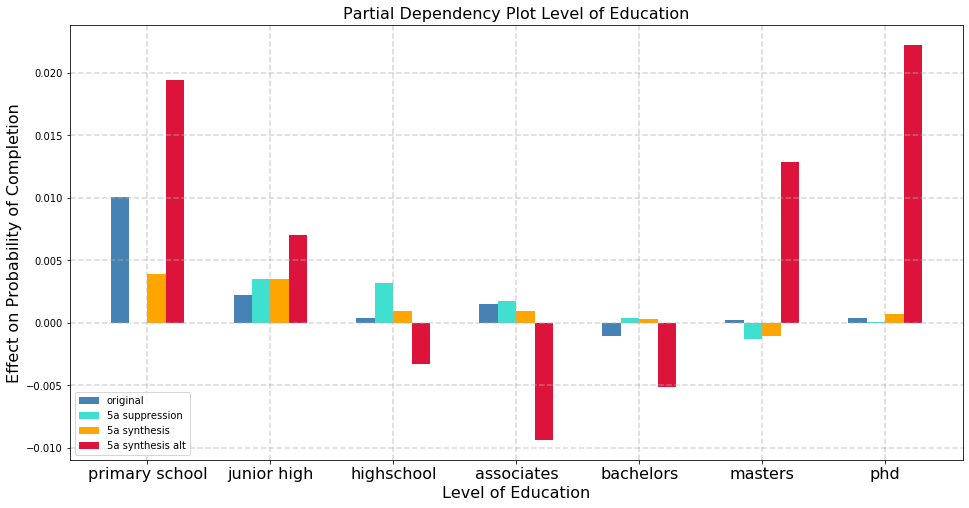

In [210]:
plt.figure(figsize = (16, 8))
N = 7
ind = np.arange(N) 
width = 0.15       
plt.bar(ind, diff_loe_orig[1:8], width, label='original', color = 'steelblue')
plt.bar(ind + width, diff_loe_5a_sup[0:7], width, label='5a suppression', color = 'turquoise')
plt.bar(ind + 2*width, diff_loe_5a_syn[1:8], width, label='5a synthesis', color = 'orange')
plt.bar(ind + 3*width, diff_loe_5a_syn_alt[1:8], width, label='5a synthesis alt', color = 'crimson')

title = 'Partial Dependency Plot Level of Education'
plt.title(title, fontsize = 16)
plt.ylabel('Effect on Probability of Completion', fontsize='16')
plt.xlabel('Level of Education',fontsize='16')
plt.grid(True, lw=1.5, ls='--', alpha=0.5)
plt.xticks(ind + 3*width / 2, ('primary school', 'junior high', 'highschool', 'associates', 'bachelors', 'masters', 'phd'), fontsize='16')
plt.legend(loc='best')
plt.show()

#### Comment
Here, looking at the effect of level of education we see that surprisingly the more educated people are less likely to complete the course, and again there is variability between datasets, with the difference being the largest for the 5a syn alt dataset.

*Partial Dependency Plot Economic Development of Country*

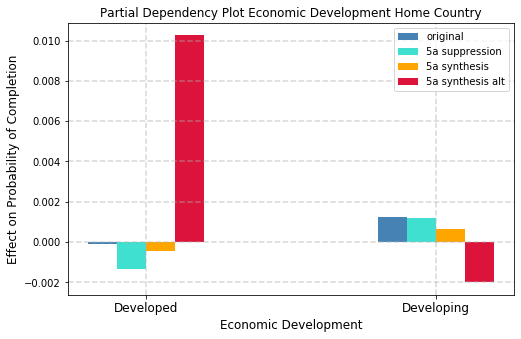

In [209]:
plt.figure(figsize = (8, 5))
N = 2
ind = np.arange(N) 
width = 0.1      
plt.bar(ind, diff_eg_orig, width, label='original', color = 'steelblue')
plt.bar(ind + width, diff_eg_5a_sup, width, label='5a suppression', color = 'turquoise')
plt.bar(ind + 2*width, diff_eg_5a_syn, width, label='5a synthesis', color = 'orange')
plt.bar(ind + 3*width, diff_eg_5a_syn_alt, width, label='5a synthesis alt', color = 'crimson')

title = 'Partial Dependency Plot Economic Development Home Country'
plt.title(title, fontsize = 12)
plt.ylabel('Effect on Probability of Completion', fontsize='12')
plt.xlabel('Economic Development',fontsize='12')
plt.grid(True, lw=1.5, ls='--', alpha=0.5)
plt.xticks(ind +3*width/2, ('Developed', 'Developing'), fontsize='12')
plt.legend(loc='best')
plt.show()

#### Comment
Here, looking at the effect of economic development in country of origin, we again see variability across the datasets as well as the alternative synthetic dataset reversing and exarcerbating the trends.

*Partial Dependency Plot Status of Account (active or inactive*

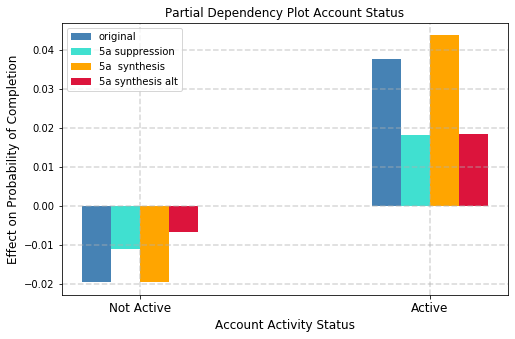

In [208]:
plt.figure(figsize = (8, 5))
N = 2
ind = np.arange(N) 
width = 0.1      
plt.bar(ind, diff_sa_orig, width, label='original', color = 'steelblue')
plt.bar(ind + width, diff_sa_5a_sup, width, label='5a suppression', color = 'turquoise')
plt.bar(ind + 2*width, diff_sa_5a_syn, width, label='5a  synthesis', color = 'orange')
plt.bar(ind + 3*width, diff_sa_5a_syn_alt, width, label='5a synthesis alt', color = 'crimson')

title = 'Partial Dependency Plot Account Status'
plt.title(title, fontsize = 12)
plt.ylabel('Effect on Probability of Completion', fontsize='12')
plt.xlabel('Account Activity Status',fontsize='12')
plt.grid(True, lw=1.5, ls='--', alpha=0.5)
plt.xticks(ind +3*width/2, ('Not Active', 'Active'), fontsize='12')
plt.legend(loc='best')
plt.show()

#### Comment
Here, looking at the effect of account status, we see that having an active account favors course completion, again with variability across datasets.

In general, though the effect sizes for the categorical features were smaller than for the numeric features, they exhibited variability among the different datasets and in the case of the 5 anonymous dataset achieved through our alternative synthetic record generation procedure, would lead to very different generated hypotheses when compared with the original.

### Friedman's H Statistic

Friedman’s H-statistic determines whether two features have an interaction effect by seeing the degree to which their joint partial dependence can be decomposed into the sum of their individual partial dependencies. That is, if two features do not interact, their joint partial dependence function will be the sum of their individual dependency functions. Here for features j and k:

$$PD_jk(x_j, x_k) = PD_j(x_j) + PD_k(x_k)$$

The H-statistic calculates the variance of the difference between the joint partial dependence function of two features (j, k) and the sum of their individual partial dependence functions. Mathematically is is calculated as [1]:

$$H^2_{jk}=\frac{\sum_{i=1}^{n}[PD_jk(x_j^i, x_k^i) - PD_j(x_j^i) - PD_k(x_k^i)]^2}{\sum_{i=1}^{n}PD^2_jk(x_j^i, x_k^i)}$$

H is 0 if there is no interaction and 1 if all of the effects of the two features 
come from their interaction.

Here, to examine what effects different methods of making the dataset 5 anonymous have on the interaction of features in the model, we have calculated interaction effects for features from the following datasets: 

* The original Dataset
* The original made 5 anonymous by supression
* The original made 5 anonymous by synthesis
* The original made 5 anonymous by synthesis alternative method

Our preliminary analysis suggested that for the most part the strongest interaction effects involved the numeric variables, so in the interest of clarity, here we have calculated interaction effects only for the numeric features. 


Also, for reasons of software compatability, we have used an alternative tree ensemble model here to make the H calculations, a GradientBoostingClassifier. However, both models are tree based ensemble methods and their accuracies on the test data are nearly identical (97.8% ,97.2%) and their precision, recall, and f1 scores are also very similar.

#### Calculations

*original dataset calculations*

In [76]:
from sklearn_gbmi import *
from sklearn.ensemble import GradientBoostingClassifier

In [127]:
# Using a GradientBoostingClassifier,  another Tree-based ensemble classifier
mod = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
        max_depth=100, random_state=0)

mod.fit(X_train_orig, y_train_orig)

y_pred_test_mod_orig = mod_orig.predict(X_test_orig)
print(f"RF Test Set Accuracy: {100*accuracy_score(y_test_orig, y_pred_test_mod_orig):.4f}%")
print("RF Test Set Classification Report:")
print(classification_report(y_test_orig, y_pred_test_mod_orig))

RF Test Set Accuracy: 97.2403%
RF Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2884
           1       0.78      0.78      0.78       196

    accuracy                           0.97      3080
   macro avg       0.88      0.88      0.88      3080
weighted avg       0.97      0.97      0.97      3080



In [108]:
col_list = ['num_log_events','num_days_active','num_chapters_visited', 'num_forum_posts',
                'total_time_seconds']

In [110]:
# function to get interactions for a given target
def get_H_interactions(model, target, dataframe, columns):
    inters = []
    for col in columns:
        z = [target, col]
        inters.append(h(model, dataframe, indices_or_columns=z))
    return inters, columns, target

In [120]:
# getting interactions
int_nle_orig, cols_nle_orig, target_nle_orig = get_H_interactions(mod_orig, 'num_log_events', X_test_orig, col_list)
int_nda_orig, cols_nda_orig, target_nda_orig = get_H_interactions(mod_orig, 'num_days_active', X_test_orig, col_list)
int_ncv_orig, cols_ncv_orig, target_ncv_orig = get_H_interactions(mod_orig, 'num_chapters_visited', X_test_orig, col_list)
int_nfp_orig, cols_nfp_orig, target_nfp_orig = get_H_interactions(mod_orig, 'num_forum_posts', X_test_orig, col_list)
int_tts_orig, cols_tts_orig, target_tts_orig = get_H_interactions(mod_orig, 'total_time_seconds', X_test_orig, col_list)
int_sa_orig, cols_sa_orig, target_sa_orig = get_H_interactions(mod_orig, 'still_active_1.0', X_test_orig, col_list)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)


*5a supression calculations*

In [131]:
# fit model to 5a supression data
mod.fit(X_train_5a_sup, y_train_5a_sup)
a=2

In [132]:
# getting interactions
int_nle_5a_sup, cols_nle_5a_sup, target_nle_5a_sup = get_H_interactions(mod, 'num_log_events', X_test_5a_sup, col_list)
int_nda_5a_sup, cols_nda_5a_sup, target_nda_5a_sup = get_H_interactions(mod, 'num_days_active', X_test_5a_sup, col_list)
int_ncv_5a_sup, cols_ncv_5a_sup, target_ncv_5a_sup = get_H_interactions(mod, 'num_chapters_visited', X_test_5a_sup, col_list)
int_nfp_5a_sup, cols_nfp_5a_sup, target_nfp_5a_sup = get_H_interactions(mod, 'num_forum_posts', X_test_5a_sup, col_list)
int_tts_5a_sup, cols_tts_5a_sup, target_tts_5a_sup = get_H_interactions(mod, 'total_time_seconds', X_test_5a_sup, col_list)
int_sa_5a_sup, cols_sa_5a_sup, target_sa_5a_sup = get_H_interactions(mod, 'still_active_1.0', X_test_5a_sup, col_list)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)


*5a synthetic calculations*

In [135]:
# fit model to 5a synthetic data
mod.fit(X_train_5a_syn, y_train_5a_syn)
a=2

In [136]:
# getting interactions
int_nle_5a_syn, cols_nle_5a_syn, target_nle_5a_syn = get_H_interactions(mod, 'num_log_events', X_test_5a_syn, col_list)
int_nda_5a_syn, cols_nda_5a_syn, target_nda_5a_syn = get_H_interactions(mod, 'num_days_active', X_test_5a_syn, col_list)
int_ncv_5a_syn, cols_ncv_5a_syn, target_ncv_5a_syn = get_H_interactions(mod, 'num_chapters_visited', X_test_5a_syn, col_list)
int_nfp_5a_syn, cols_nfp_5a_syn, target_nfp_5a_syn = get_H_interactions(mod, 'num_forum_posts', X_test_5a_syn, col_list)
int_tts_5a_syn, cols_tts_5a_syn, target_tts_5a_syn = get_H_interactions(mod, 'total_time_seconds', X_test_5a_syn, col_list)
int_sa_5a_syn, cols_sa_5a_syn, target_sa_5a_syn = get_H_interactions(mod, 'still_active_1.0', X_test_5a_syn, col_list)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)


*5a synthetic alternative calculations*

In [139]:
# fit model to 5a synthetic alternative data
mod.fit(X_train_5a_syn_alt, y_train_5a_syn_alt)
a=2

In [140]:
# getting interactions
int_nle_5a_syn_alt, cols_nle_5a_syn_alt, target_nle_5a_syn_alt = get_H_interactions(mod, 'num_log_events', X_test_5a_syn_alt, col_list)
int_nda_5a_syn_alt, cols_nda_5a_syn_alt, target_nda_5a_syn_alt = get_H_interactions(mod, 'num_days_active', X_test_5a_syn_alt, col_list)
int_ncv_5a_syn_alt, cols_ncv_5a_syn_alt, target_ncv_5a_syn_alt = get_H_interactions(mod, 'num_chapters_visited', X_test_5a_syn_alt, col_list)
int_nfp_5a_syn_alt, cols_nfp_5a_syn_alt, target_nfp_5a_syn_alt = get_H_interactions(mod, 'num_forum_posts', X_test_5a_syn_alt, col_list)
int_tts_5a_syn_alt, cols_tts_5a_syn_alt, target_tts_5a_syn_alt = get_H_interactions(mod, 'total_time_seconds', X_test_5a_syn_alt, col_list)
int_sa_5a_syn_alt, cols_sa_5a_syn_alt, target_sa_5a_syn_alt = get_H_interactions(mod, 'still_active_1.0', X_test_5a_syn_alt, col_list)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)


#### Interaction Plots for Numeric Variables

In [170]:
l_nle = [int_nle_orig, int_nle_5a_sup, int_nle_5a_syn, int_nle_5a_syn_alt]
l_nda = [int_nda_orig, int_nda_5a_sup, int_nda_5a_syn, int_nda_5a_syn_alt]
l_ncv = [int_ncv_orig, int_ncv_5a_sup, int_ncv_5a_syn, int_ncv_5a_syn_alt]
l_nfp = [int_nfp_orig, int_nfp_5a_sup, int_nfp_5a_syn, int_nfp_5a_syn_alt]
l_tts = [int_tts_orig, int_tts_5a_sup, int_tts_5a_syn, int_tts_5a_syn_alt]

In [174]:
def make_combine_interaction_plot(list_target, col_list, target, plot_size=(16, 8)):
    plt.figure(figsize = plot_size)
    N = len(col_list)
    ind = np.arange(N) 
    width = 0.15
    plt.bar(ind, list_target[0], width, label='original', color = 'steelblue')
    plt.bar(ind + width, list_target[1], width, label='5a suppression', color = 'turquoise')
    plt.bar(ind + 2*width, list_target[2], width, label='5a synthetic', color = 'orange')
    plt.bar(ind + 3*width, list_target[3], width, label='5a synthetic alt', color = 'crimson')

    title = 'Interaction Plot ' + target
    plt.title(title, fontsize = 16)
    plt.ylabel('Interaction Strength with '+ target, fontsize='14')
    plt.xlabel('Features',fontsize='16')
    plt.grid(True, lw=1.5, ls='--', alpha=0.5)
    plt.xticks(ind + 3*width / 2, col_list, fontsize='14')
    plt.legend(loc='upper left')
    plt.show()

*num_log_events*

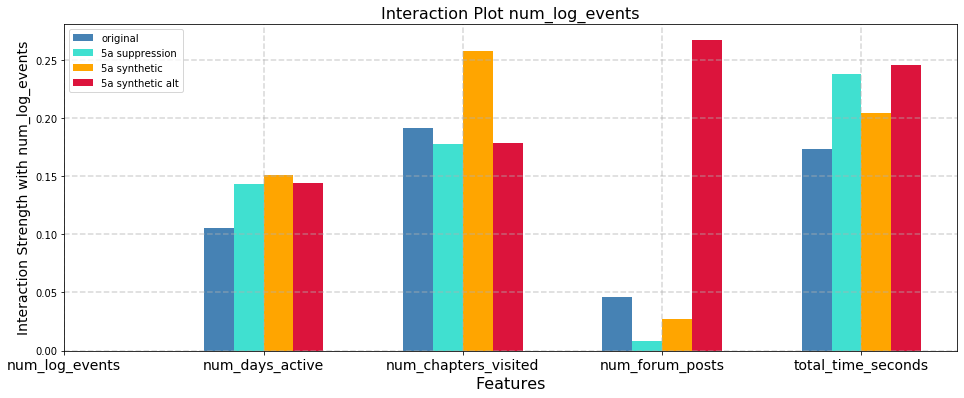

In [197]:
# Making Interaction Plots
make_combine_interaction_plot(l_nle, col_list, 'num_log_events', plot_size=(16, 6))

#### Comment
Here, looking at the interaction effect of the number of log events with the other numeric variables, we see some fairly large interactions > 0.25, and variability across datasets. Furthermore, which 5a-anonymous method yields results closest to the original datset varies from feature to feature.

The interaction between num_log_events and num_forum_posts is greatly exaggerated in the 5a_synthetic_alt dataset.

*num_days_active*

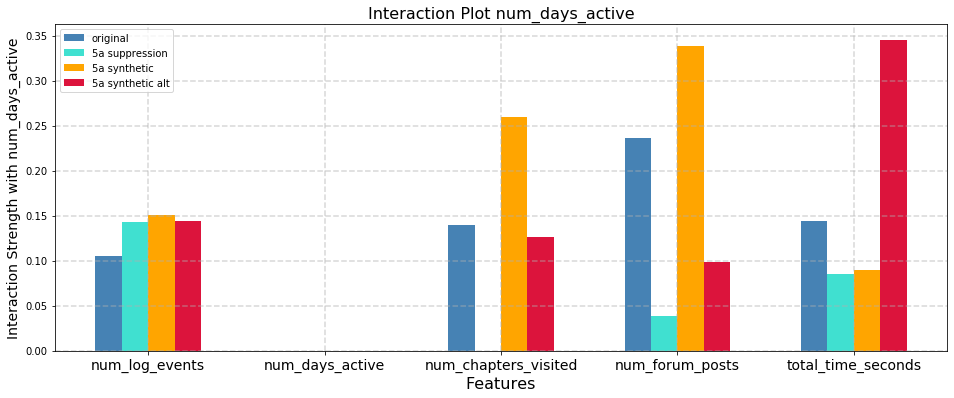

In [198]:
make_combine_interaction_plot(l_nda, col_list, 'num_days_active', plot_size=(16, 6))

#### Comment
Here, looking at the interaction effect of the number of days active with the other numeric variables, we see similar results to the previous graph. Notably, sometimes there are large difference in interaction strength between datasets, here with num_forum posts for example, the suppression methods underestimates the true interaction, while the sythesis approach over estimates it.

*num_chapter_visits*

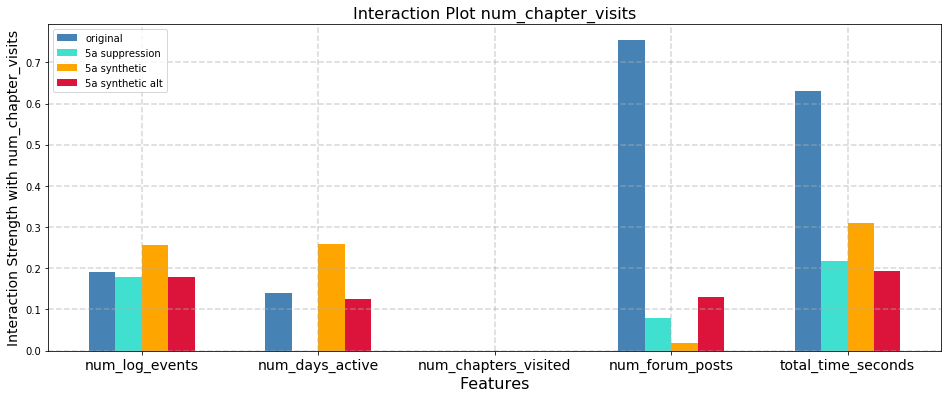

In [199]:
make_combine_interaction_plot(l_ncv, col_list, 'num_chapter_visits', plot_size=(16, 6))

#### Comment
Here, looking at the interaction effect of the number of chapters visited with the other numeric variables, we see similar results to the previous interaction graphs. Notably, interaction strength is grossly underestimated in all the 5a datasets for interaction with num_forum_posts, and total_time_seconds.

*num_forum_posts*

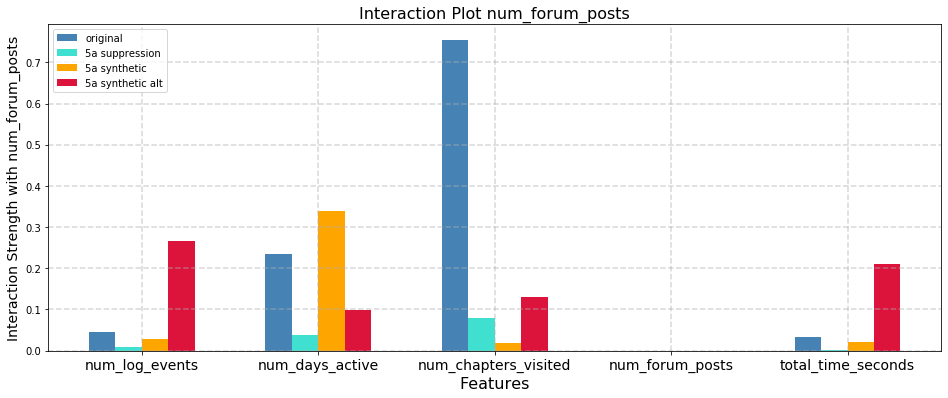

In [200]:
make_combine_interaction_plot(l_nfp, col_list, 'num_forum_posts', plot_size=(16, 6))

#### Comment
Here, looking at the interaction effect of the number of forum posts with the other numeric variables, we see similar results to the previous interaction graphs, substantial variability across datasets.

*total_time_seconds*

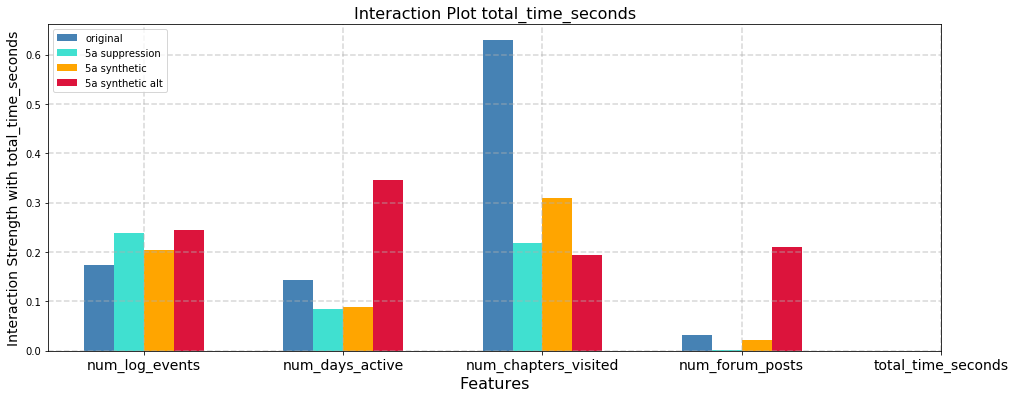

In [201]:
make_combine_interaction_plot(l_tts, col_list, 'total_time_seconds', plot_size=(16, 6))

#### Comment
Here, looking at the interaction effect of the total time spent on the course with the other numeric variables, we see similar results to the previous interaction graphs. With some features, how one makes the data 5 anonymous influences greatly to what degree interaction effects are preserved.

### Permutation Importance

Permutation importance is a very simple and intuitive measure of how important an individual feature is for a model's predictive power.

The permutation importance for a feature is the decrease/increase in a chosen metric on the test set after a feature has been randomly permuted columnwise. Specifically, let 

\begin{align}
X = \begin{pmatrix}
x_{11} & \cdots \\
x_{12} & \cdots \\
\vdots & \ddots \\
\end{pmatrix}
\end{align}

be a design matrix with $X \in \mathbb{R}^{mxn}$. Let $\sigma$ be a permutation of the set $\{1,\cdots,n\}$. Then we choose a column j and modify X to obtain:

\begin{align}
\tilde{X} = \begin{pmatrix}
x_{11} & \cdots & x_{\sigma(1)j} & \cdots \\
x_{12} & \cdots & x_{\sigma(2)j} & \cdots \\
\vdots & \ddots & \vdots & \cdots \\
\end{pmatrix}
\end{align}

This permutation effectively breaks the relationship between the predictor and the target. 

We then determine the new value of the metric under $\tilde{X}$. More important features tend to have have a change of larger magnitude. In this case, we are concerned with accuracy, so the permutation importance of feature j is the decrease in test set accuracy under the permutation of column j in the modified test set $\tilde{X}$ compared against the original accuracy of X. One can perform multiple random permutations and obtain a distribution of accuracy changes. Because this technique only depends on the inputs and outputs of a model, it is model agnostic.


It does have its drawbacks, however. The primary drawback is that if a feature is highly correlated with another feature, it will not appear to be important because the feature with which it is correlated will maintain the pair's predictive power even when the other feature has been permuted. There are pairwise permutation importance metrics which address this.


#### Original

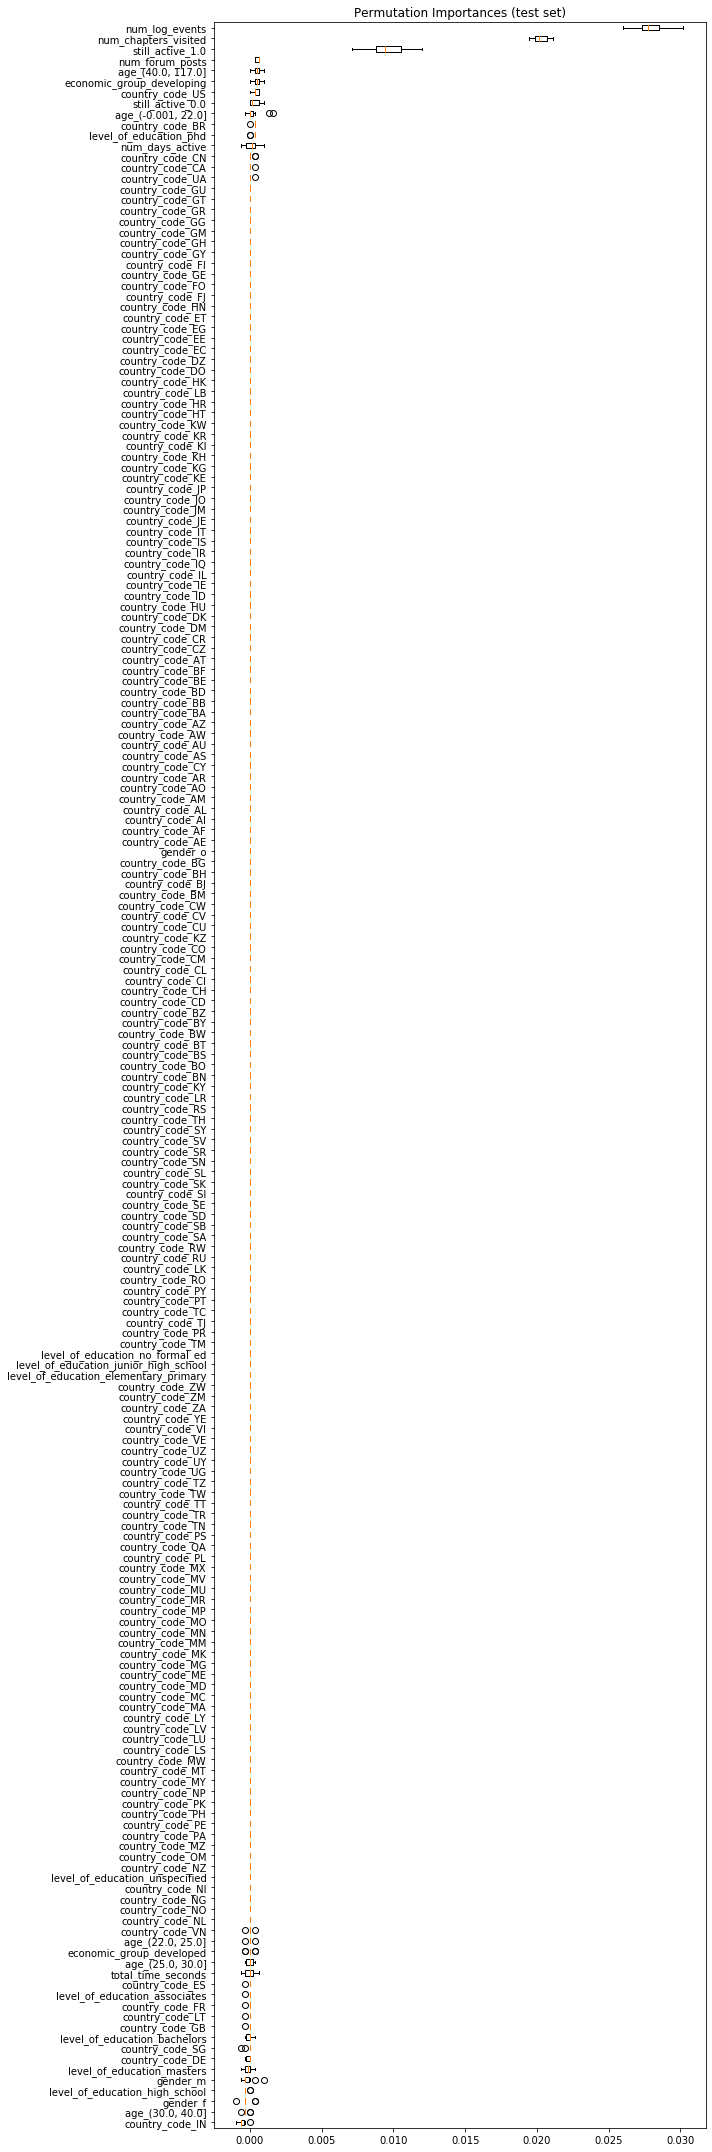

In [35]:
from sklearn.inspection import permutation_importance

def do_perm_imp(rf, X_test, y_test):
    result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                    random_state=42, n_jobs=4)
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots(figsize=(10, 30))
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X_test.columns[sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    fig.tight_layout()
    plt.show()
    
do_perm_imp(rf_orig, X_test_orig, y_test_orig)    

We note that the most important feature's removal decreases the classifier's accuracy by ~2.5 precent which drops it close to the baseline of ~94%. 

The above plot makes our random forest classifier interpretable. The features that matter, in increasing order of importance, are

* whether the user is still active on ed
* the number of log events generated by the user
* the number of chapters visited by the user.

This is line with our intuition that the degree to which one engages with a course and is committed to using EdX as a resource in general matters for success.

None of the other features seem to matter, which is in line with our normative view that success ought to be based on effort and not things largely outside of one's control such as nationality, gender, or age.

#### 5-anonymous: Suppression

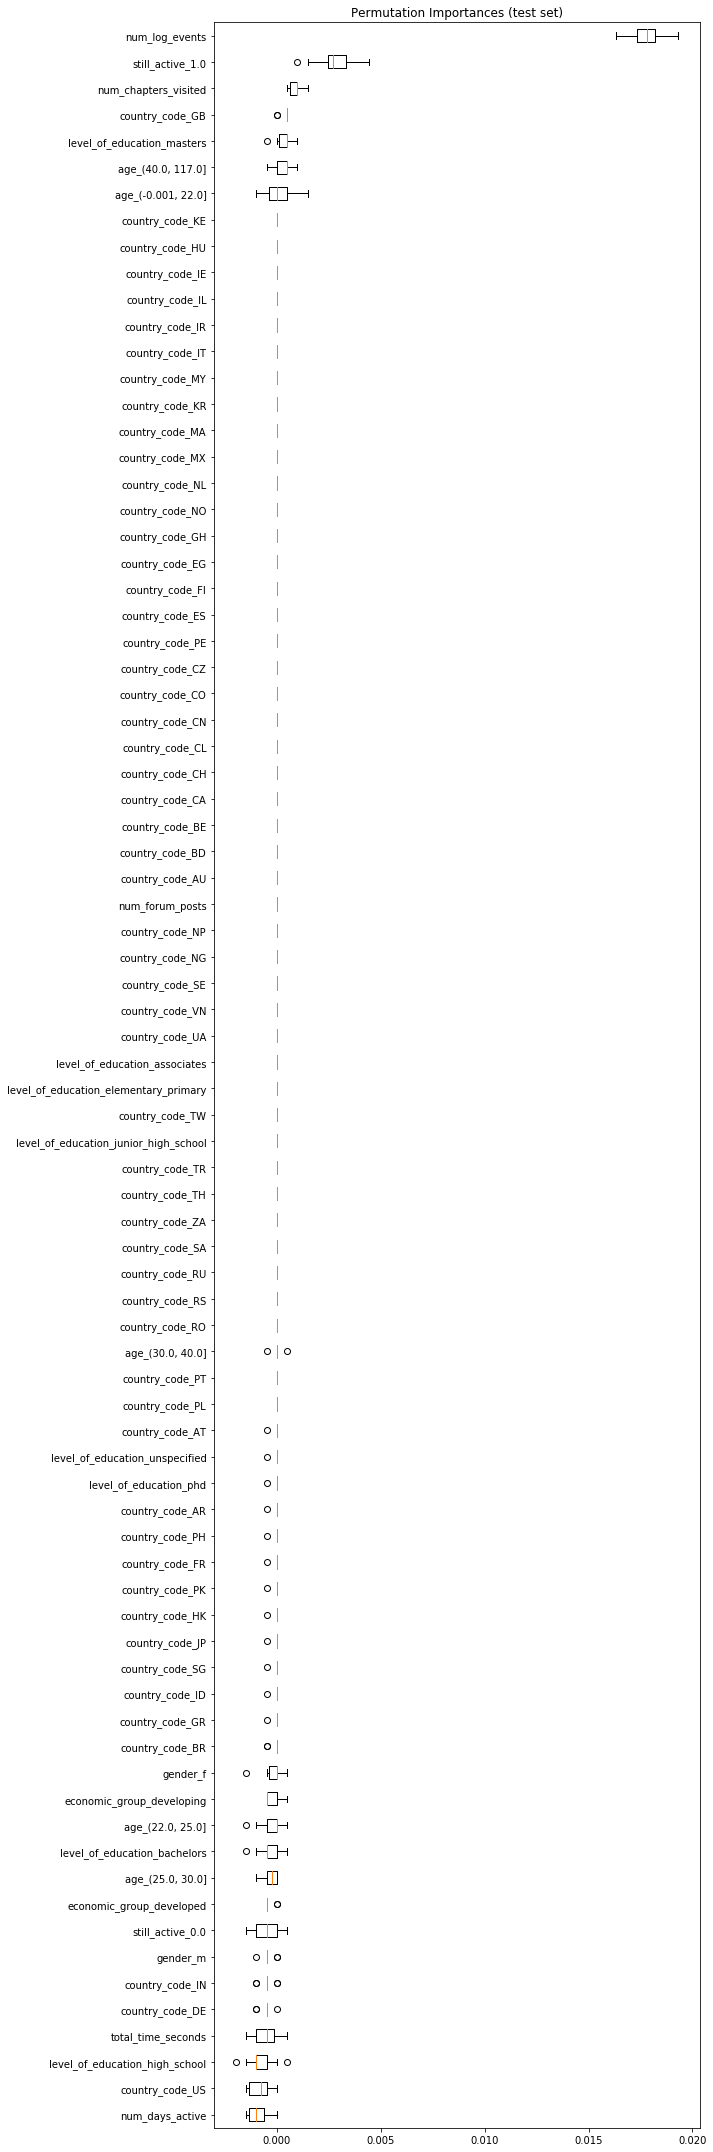

In [61]:
do_perm_imp(rf_5a_sup, X_test_5a_sup, y_test_5a_sup)  

Interestingly enough, the 3 most important features have remained the same, but the number of chapters visited is now a much less important feature, which weakens the hypothesis generated from the original permutation importance plot. The number of chapters visited was the most important feature in original dataset, but now hardly matters. The importance of the GB country code has also increased very slightly.

#### 5-anonymous: Synthetic Record Generation

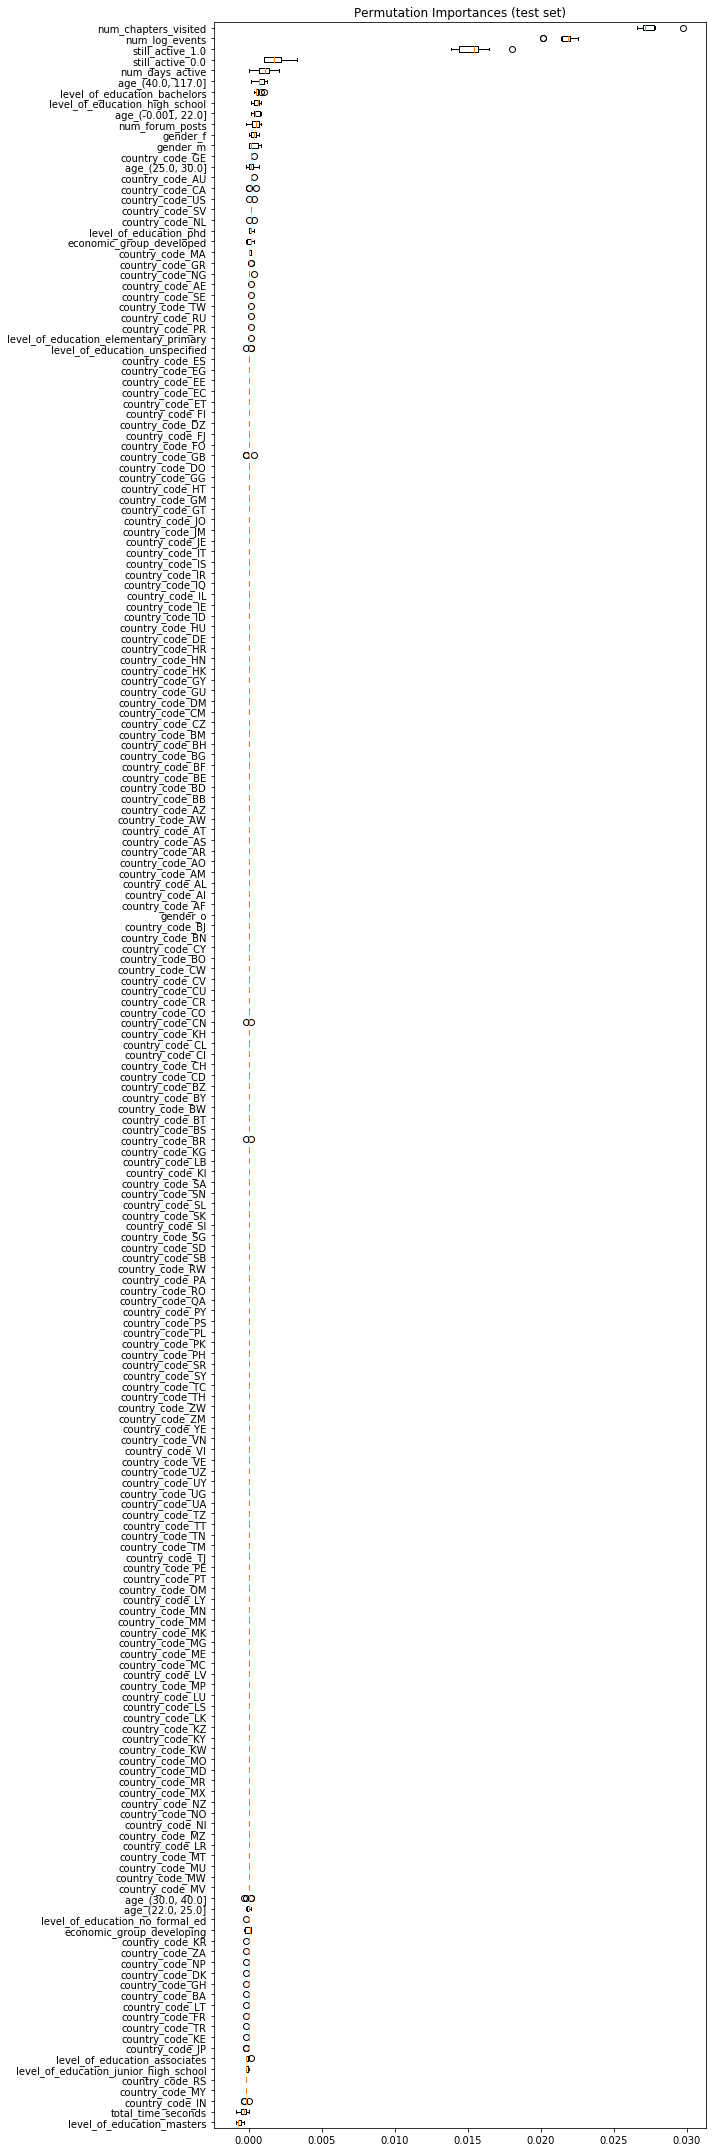

In [62]:
do_perm_imp(rf_5a_syn, X_test_5a_syn, y_test_5a_syn) 

In this case, the synthetic records did not affect the permutation importances much because the most important features and the target were drawn from the empirical data distribution and the quasi-identifiers were not important for model prediction. The manner in which we generated synthetic records would only affect the relationship between the target and the quasi-identifiers.

#### 5-anonymous: Synthetic Record Generation (alternate)

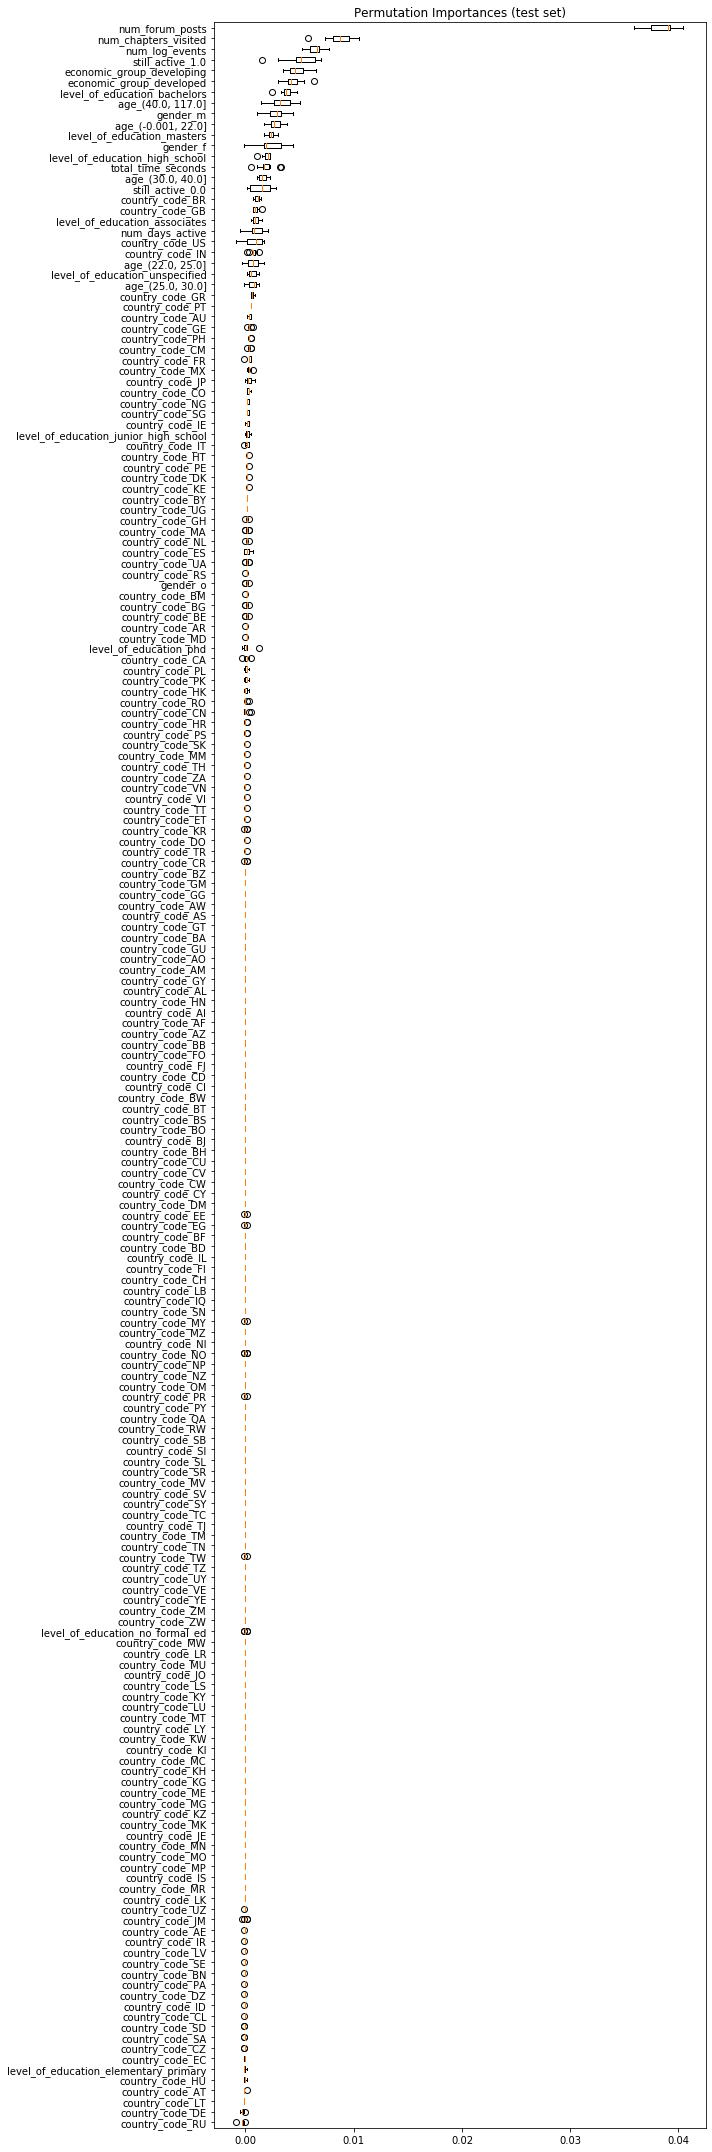

In [63]:
do_perm_imp(rf_5a_syn_alt, X_test_5a_syn_alt, y_test_5a_syn_alt) 

The most important features have changed. In this case, the number of forum posts, an unimportant feature before, is now the most important. is_active, num_chapters_visited, and num_log_events do not matter as much anymore. This provides evidence that the manner in which synthetic records are generated affects the permutation importances. The hypothesis generated under the original dataset is weakened under this one because fewer "effort based" features are deemed to be really important.

#### 5-anonymous: Blurring and Generalization

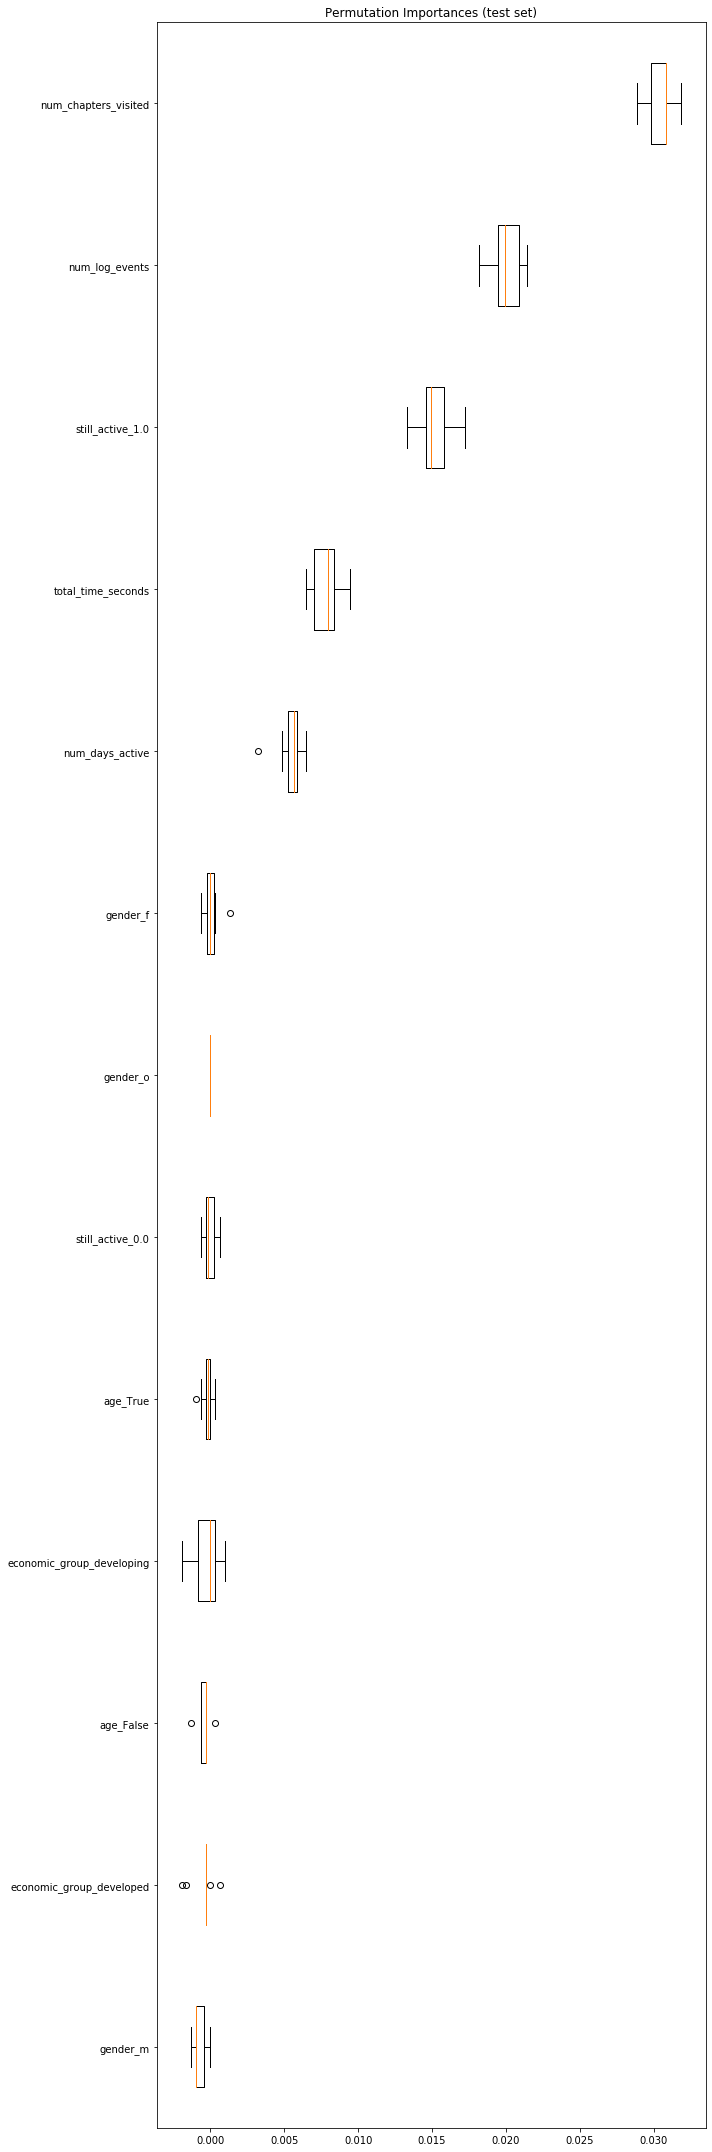

In [64]:
do_perm_imp(rf_5a_blurred_generalized, X_test_5a_blurred_generalized, y_test_5a_blurred_generalized) 


In this case there was no effect for this method of enforcing 5-anonymity because the features that were blurred and generalized were not salient for predicting course completion.

#### Alternate Imputation


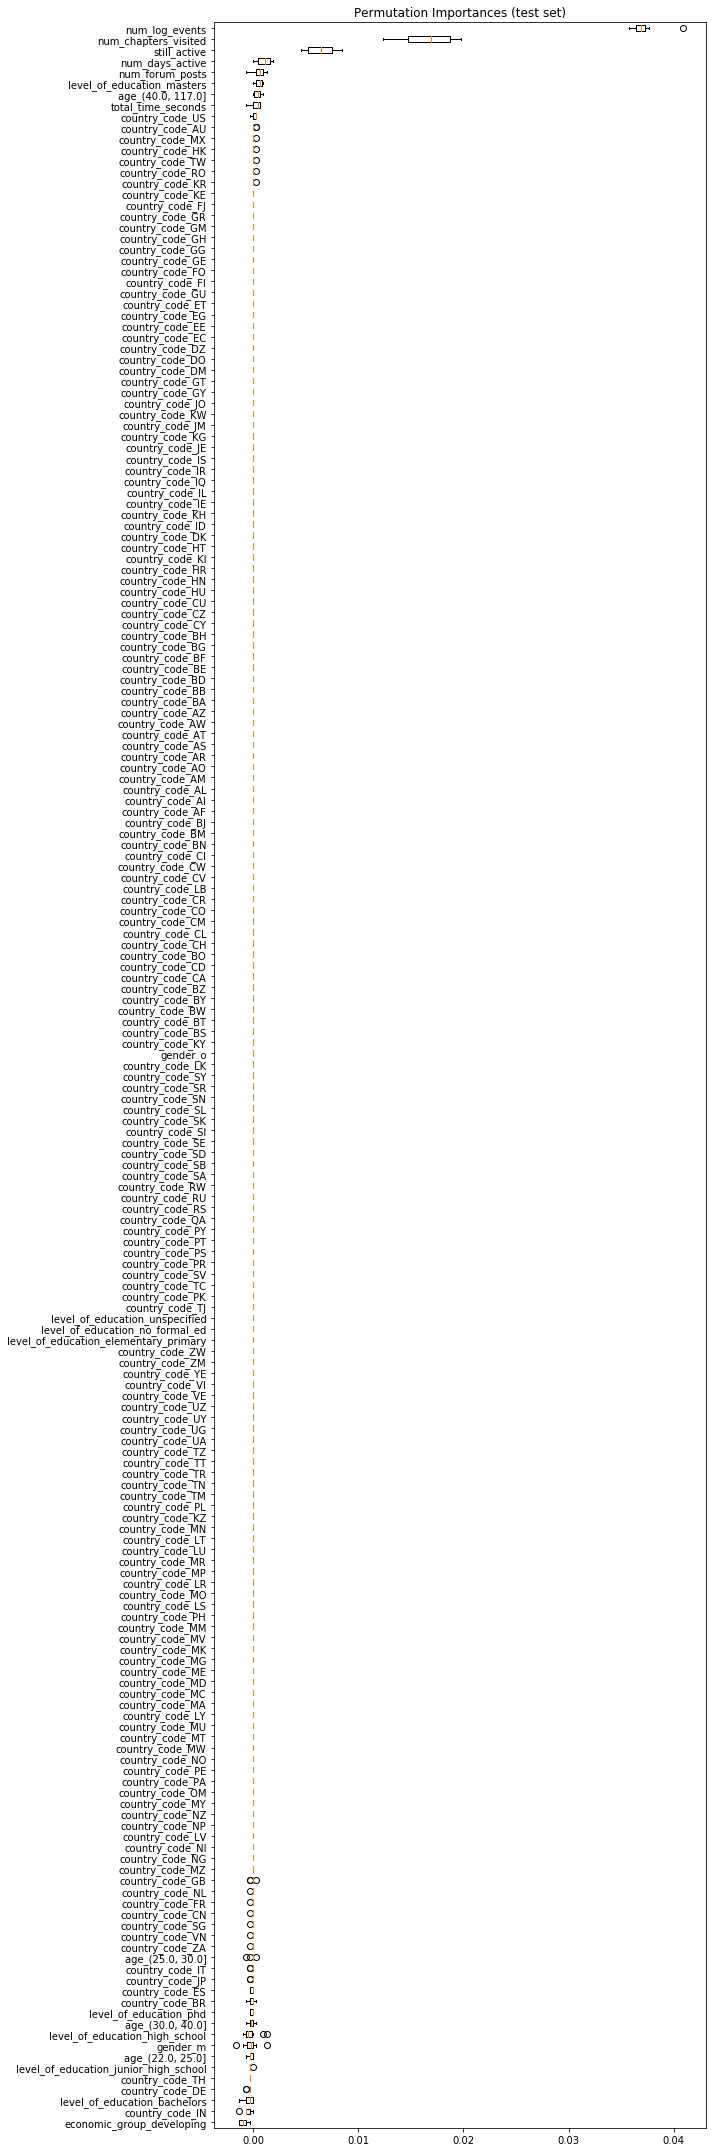

In [36]:

do_perm_imp(rf_feats_alt_imp, 
            X_test_feats_alt_imp,
            y_test_feats_alt_imp
) 

The alternate data imputation technique in this case did not drastically affect the permutation importances. The number of log events is now more important than the number of chapters visited, but this is a negligible change. Nonetheless, a change in the ordering of the importance of the features could lead to different hypothesis generation.

#### Random Duplicates

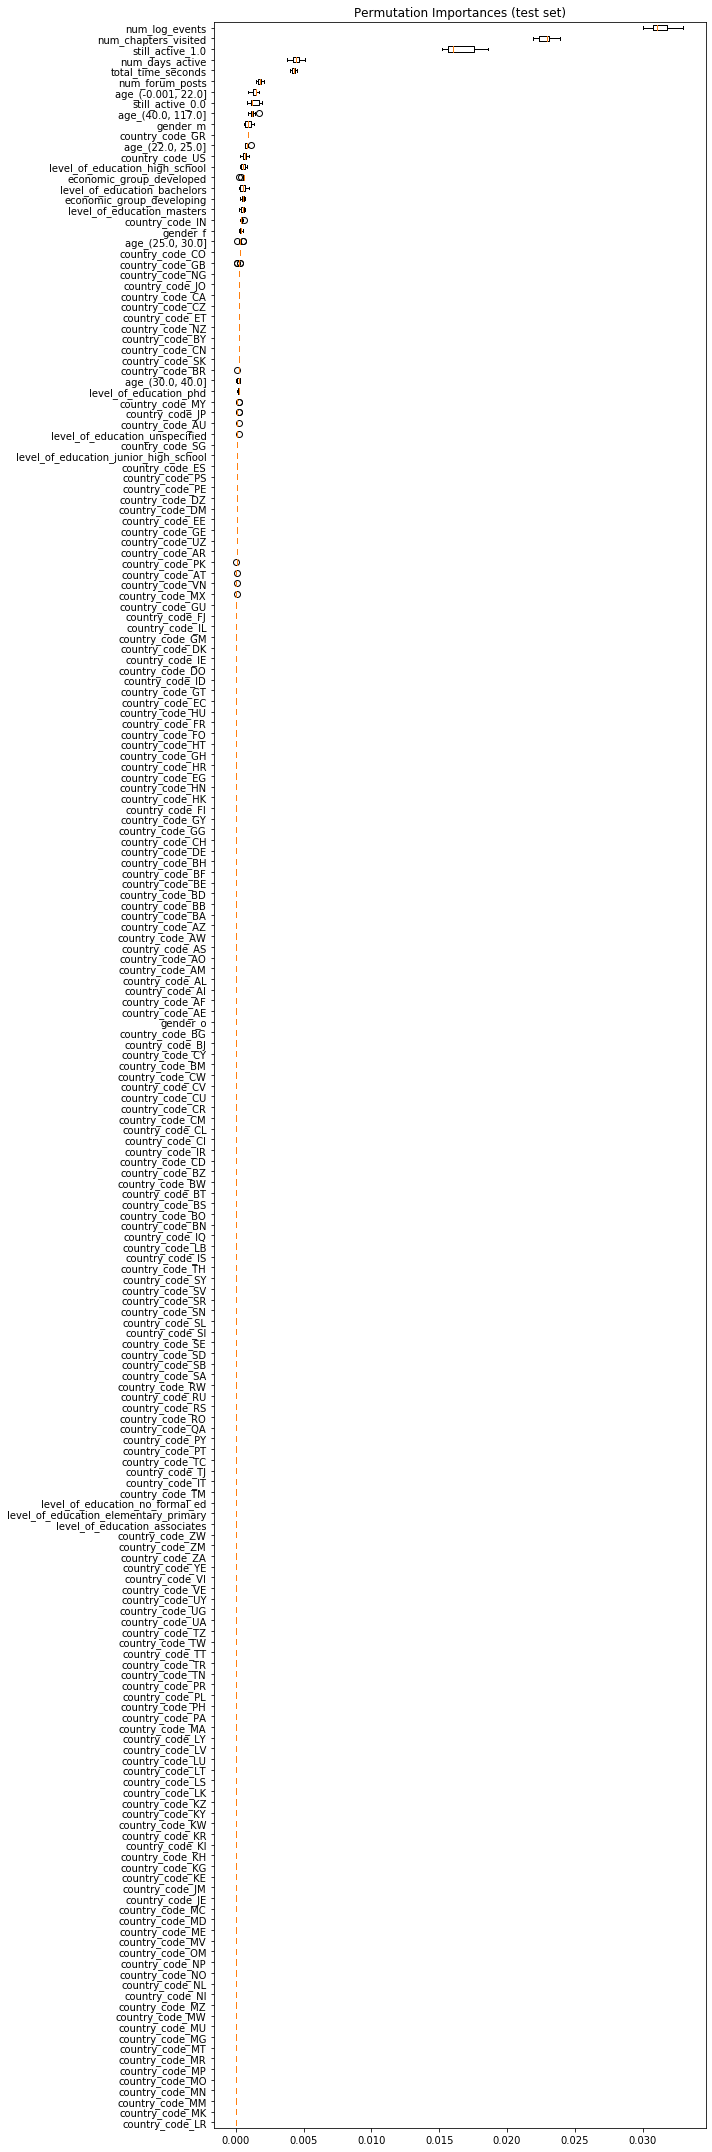

In [37]:



do_perm_imp(rf_feats_duplicates, 
            X_test_feats_duplicates,
            y_test_feats_duplicates
) 


The importances here are largely the same as well, which makes sense. The duplicates here are coming from the empirical data distribution.

#### Systematic Duplicates

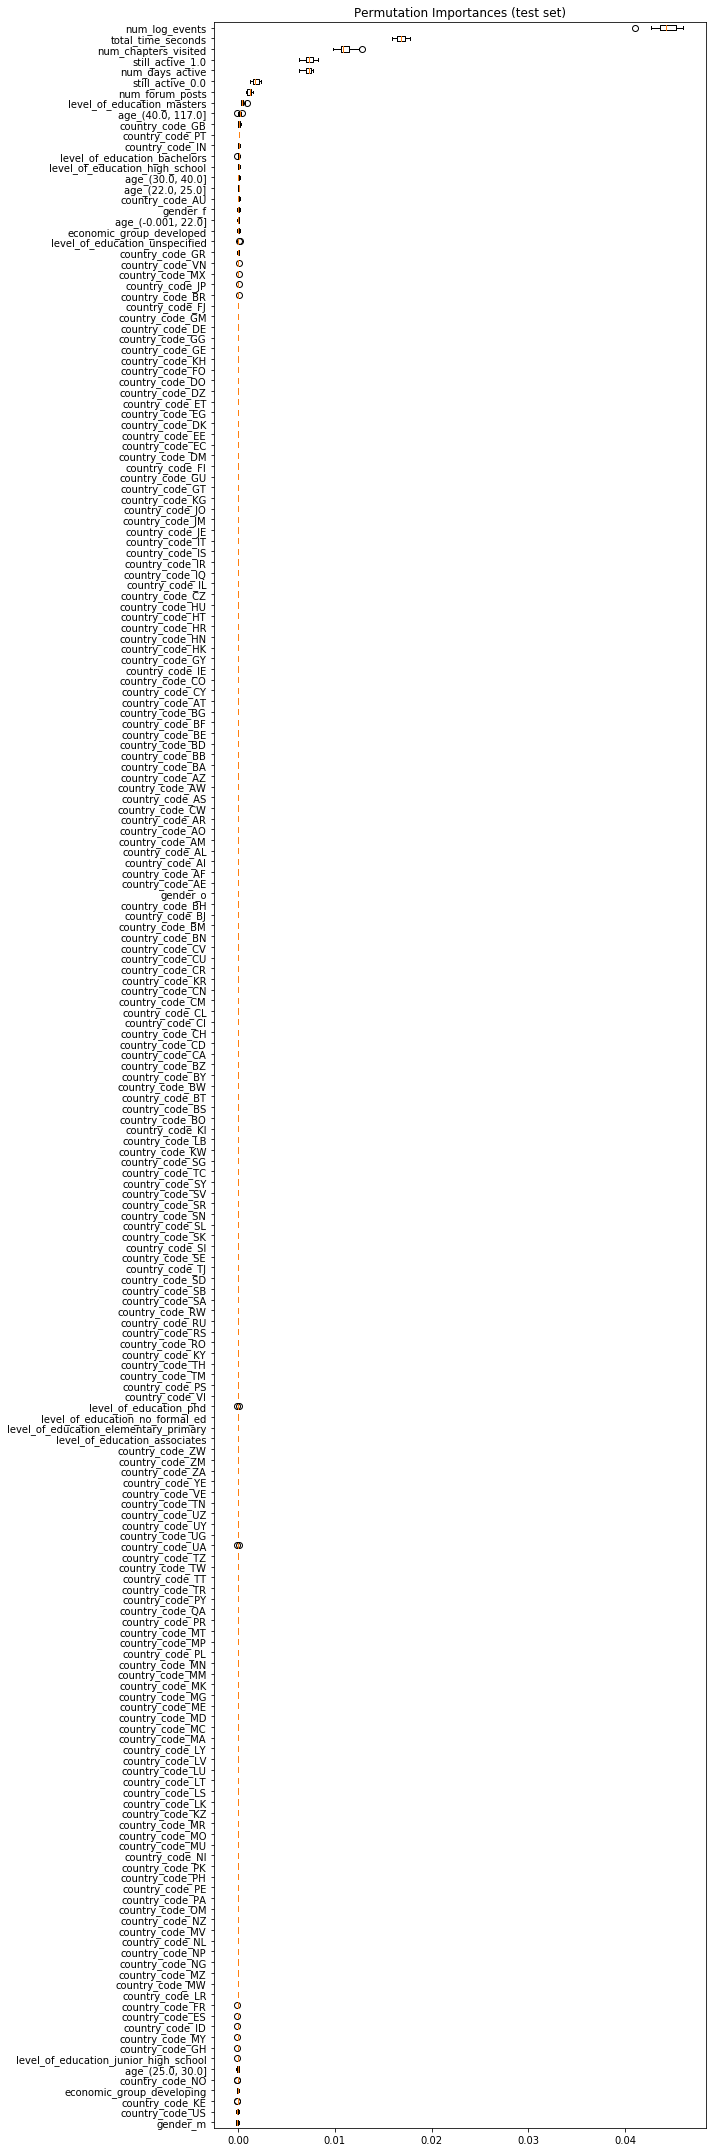

In [38]:
do_perm_imp(rf_feats_duplicates_sys, 
            X_test_feats_duplicates_sys,
            y_test_feats_duplicates_sys
) 

Though the permutation importances did not change drastically, the importance of num_chapters_visited decreased substantially and the importance of total_time_seconds increased. As commented before, the order of the most important features and the magnitude of their importance can effect the generated hypotheses.

### Global Surrogates

<img src="./img/global_surrogates.png">

A global surrogate model is simply an inherently interpretable model trained using the predictions from the black-box model and also using the same features. One uses the interpretabiliy mechanism present in the inherently interpretable model to assess what the black-box model is doing. In this case, we use logistic regression and inspect the regression coefficients for feature effects and p-values for feature importance.

##### Original

In [68]:
# For numerical stabiliy, we do not regress on the country codes.
lr_feats = [
'num_log_events',
 'num_days_active',
 'num_chapters_visited',
 'num_forum_posts',
 'total_time_seconds',
 'economic_group_developed',
 'economic_group_developing',
 'level_of_education_associates',
 'level_of_education_bachelors',
 'level_of_education_elementary_primary',
 'level_of_education_high_school',
 'level_of_education_junior_high_school',
 'level_of_education_masters',
 'level_of_education_no_formal_ed',
 'level_of_education_phd',
 'level_of_education_unspecified',
 'Q("age_(-0.001, 22.0]")',
 'Q("age_(22.0, 25.0]")',
 'Q("age_(25.0, 30.0]")',
 'Q("age_(30.0, 40.0]")',
 'Q("age_(40.0, 117.0]")',
 'gender_f',
 'gender_m',
 'gender_o',
 'Q("still_active_0.0")',
 'Q("still_active_1.0")'
]



In [70]:
import statsmodels.api as sm
import statsmodels.formula.api as smf



y_pred_test = rf_orig.predict(X_test_orig)

df_lr_orig = pd.concat((pd.Series(y_pred_test).rename('completed').to_frame(), X_test_orig.reset_index(drop=True)), axis=1)

f = 'completed ~ ' + '+'.join(lr_feats)
lr_orig = smf.logit(formula = f, data = df_lr_orig).fit(maxiter=35)

lr_orig.summary()

         Current function value: 0.010077
         Iterations: 35


/Users/michaeldowns/miniconda3/envs/ac221/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              completed   No. Observations:                 3080
Model:                          Logit   Df Residuals:                     3053
Method:                           MLE   Df Model:                           26
Date:                Tue, 28 Apr 2020   Pseudo R-squ.:                  0.9562
Time:                        19:54:42   Log-Likelihood:                -31.039
converged:                      False   LL-Null:                       -707.84
Covariance Type:            nonrobust   LLR p-value:                2.311e-269
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                               -66.6994   3.76e+06  -1.77e-05      1.000   -7.37e+06    7.37e+06
num_log_events                            0.0076      0.002      3.568      0.000       0.003       0.012
num_days_active                           0.0119      0.033      0.357      0.721      -0.054       0.077
num_chapters_visited                      0.3625      0.084      4.338      0.000       0.199       0.526
num_forum_posts                          -0.0457      0.077     -0.592      0.554      -0.197       0.105
total_time_seconds                        0.0001      0.000      0.900      0.368      -0.000       0.000
economic_group_developed                  7.3779    796.084      0.009      0.993   -1552.917    1567.673
economic_group_developing                 8.1837    796.084      0.010      0.992   -1552.111    1568.479
level_of_education_associates             0.5054      6.110      0.083      0.934     -11.469      12.480
level_of_education_bachelors              0.7209      5.389      0.134      0.894      -9.841      11.283
level_of_education_elementary_primary    -0.1776   2560.428  -6.94e-05      1.000   -5018.524    5018.169
level_of_education_high_school           -0.4219      5.311     -0.079      0.937     -10.831       9.987
level_of_education_junior_high_school    -1.0935      6.856     -0.160      0.873     -14.530      12.343
level_of_education_masters               -0.4506      5.444     -0.083      0.934     -11.121      10.219
level_of_education_no_formal_ed           3.7135      8.752      0.424      0.671     -13.441      20.868
level_of_education_phd                    1.4893      5.624      0.265      0.791      -9.534      12.513
level_of_education_unspecified           -0.7868      5.650     -0.139      0.889     -11.860      10.286
Q("age_(-0.001, 22.0]")                  -0.2623      8.585     -0.031      0.976     -17.088      16.564
Q("age_(22.0, 25.0]")                    -1.8438      8.627     -0.214      0.831     -18.752      15.064
Q("age_(25.0, 30.0]")                    -0.2874      8.632     -0.033      0.973     -17.207      16.632
Q("age_(30.0, 40.0]")                    -2.3994      8.612     -0.279      0.781     -19.279      14.480
Q("age_(40.0, 117.0]")                   -3.7450      8.651     -0.433      0.665     -20.700      13.210
gender_f                                  1.1898      8.695      0.137      0.891     -15.853      18.232
gender_m                                  1.9605      8.719      0.225      0.822     -15.129      19.050
gender_o                                -89.6784   1.13e+20  -7.93e-19      1.000   -2.22e+20    2.22e+20
Q("still_active_0.0")                  -171.3516    1.4e+41  -1.22e-39      1.000   -2.75e+41    2.75e+41
Q("still_active_1.0")                    41.2210   3.76e+06    1.1e-05      1.000   -7.37e+06    7.37e+06
=============================================================

The above coefficients and p-values match the permutation importance and partial dependence plots quite well. The only important features are num_log_events and num_chapters_visited, which both increase the probability of passing, which suggests that the random forest is really only using those features.

##### 5-anonymous: Suppression


In [42]:
def make_formula_string(data, ignore=[]):
    f = 'completed ~ '
    
    for feat in data.columns:
        if 'country_code' in feat or feat in ignore:
            pass
        elif ('age_' in feat) or 'still_active' in feat:
            f += f' + Q("{feat}")'
        else:
            f += f' + {feat}'
        
    return f


In [72]:
ignore = [
    'gender_f'
]

test = X_test_5a_sup
model = rf_5a_sup

y_pred_test = model.predict(test)

df_lr = pd.concat((pd.Series(y_pred_test).rename('completed').to_frame(), test.reset_index(drop=True)), axis=1)

f = make_formula_string(test, ignore=ignore)
lr_orig = smf.logit(formula = f, data = df_lr).fit(maxiter=35)

lr_orig.summary()

         Current function value: 0.002792
         Iterations: 35


/Users/michaeldowns/miniconda3/envs/ac221/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              completed   No. Observations:                 2022
Model:                          Logit   Df Residuals:                     1998
Method:                           MLE   Df Model:                           23
Date:                Tue, 28 Apr 2020   Pseudo R-squ.:                  0.9794
Time:                        19:55:36   Log-Likelihood:                -5.6455
converged:                      False   LL-Null:                       -273.63
Covariance Type:            nonrobust   LLR p-value:                 1.130e-98
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                               -55.5434   2.43e+04     -0.002      0.998   -4.76e+04    4.75e+04
num_log_events                            0.0221      0.012      1.781      0.075      -0.002       0.046
num_days_active                          -0.0249      0.185     -0.134      0.893      -0.388       0.339
num_chapters_visited                     -0.0742      0.194     -0.383      0.702      -0.454       0.306
num_forum_posts                           1.2211      3.934      0.310      0.756      -6.490       8.932
total_time_seconds                        0.0018      0.001      1.685      0.092      -0.000       0.004
economic_group_developed                 -5.0800   1764.920     -0.003      0.998   -3464.259    3454.099
economic_group_developing                -6.6580   1764.916     -0.004      0.997   -3465.831    3452.515
level_of_education_associates            13.4402    8.8e+04      0.000      1.000   -1.73e+05    1.73e+05
level_of_education_bachelors             15.7662    318.183      0.050      0.960    -607.861     639.394
level_of_education_elementary_primary    13.6660   7.94e+04      0.000      1.000   -1.56e+05    1.56e+05
level_of_education_high_school           14.9217    325.799      0.046      0.963    -623.633     653.477
level_of_education_junior_high_school    -9.2538   2.74e+06  -3.37e-06      1.000   -5.38e+06    5.38e+06
level_of_education_masters               17.6437    318.430      0.055      0.956    -606.468     641.755
level_of_education_phd                   12.9360    502.227      0.026      0.979    -971.410     997.282
level_of_education_unspecified           15.7090   8.46e+04      0.000      1.000   -1.66e+05    1.66e+05
Q("age_(-0.001, 22.0]")                  -4.6006    325.463     -0.014      0.989    -642.497     633.295
Q("age_(22.0, 25.0]")                   -14.3236    319.611     -0.045      0.964    -640.749     612.102
Q("age_(25.0, 30.0]")                   -10.4845    318.051     -0.033      0.974    -633.853     612.884
Q("age_(30.0, 40.0]")                   -18.2544    318.383     -0.057      0.954    -642.273     605.765
Q("age_(40.0, 117.0]")                  -28.0910    318.771     -0.088      0.930    -652.871     596.689
gender_m                                 -0.3698      2.428     -0.152      0.879      -5.130       4.390
Q("still_active_0.0")                   -48.5077   1.76e+05     -0.000      1.000   -3.45e+05    3.45e+05
Q("still_active_1.0")                    26.7981   2.42e+04      0.001      0.999   -4.74e+04    4.74e+04
=========================================================================================================

Possibly complete quasi-separation: A fraction 0.98 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

After suppression, no features are statistically significant at an $\alpha=0.05$ level and the sign on the num_chapters_visited coefficient changed. Thus, using this global surrogate leads to different conclusions after achieving 5-anonymity through suppression.

##### 5-anonymous: Synthetic Record Generation


In [73]:
ignore = [
    'gender_f'
]

test = X_test_5a_syn
model = rf_5a_syn

y_pred_test = model.predict(test)

df_lr = pd.concat((pd.Series(y_pred_test).rename('completed').to_frame(), test.reset_index(drop=True)), axis=1)

f = make_formula_string(test, ignore=ignore)
lr_orig = smf.logit(formula = f, data = df_lr).fit(maxiter=35)

lr_orig.summary()

         Current function value: 0.012103
         Iterations: 35


/Users/michaeldowns/miniconda3/envs/ac221/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              completed   No. Observations:                 5712
Model:                          Logit   Df Residuals:                     5686
Method:                           MLE   Df Model:                           25
Date:                Tue, 28 Apr 2020   Pseudo R-squ.:                  0.9478
Time:                        19:56:17   Log-Likelihood:                -69.135
converged:                      False   LL-Null:                       -1324.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                               -42.3020   6752.824     -0.006      0.995   -1.33e+04    1.32e+04
num_log_events                            0.0073      0.001      4.872      0.000       0.004       0.010
num_days_active                           0.0048      0.022      0.223      0.823      -0.038       0.047
num_chapters_visited                      0.3096      0.050      6.250      0.000       0.213       0.407
num_forum_posts                          -0.0159      0.027     -0.597      0.550      -0.068       0.036
total_time_seconds                     4.364e-05    8.6e-05      0.508      0.612      -0.000       0.000
economic_group_developed                 -0.9359      9.756     -0.096      0.924     -20.057      18.185
economic_group_developing                -0.5336      9.756     -0.055      0.956     -19.654      18.587
level_of_education_associates            -1.1014      1.778     -0.620      0.536      -4.586       2.383
level_of_education_bachelors              0.4642      1.220      0.380      0.704      -1.927       2.856
level_of_education_elementary_primary    -0.8633     15.169     -0.057      0.955     -30.595      28.868
level_of_education_high_school           -0.1819      1.178     -0.154      0.877      -2.491       2.127
level_of_education_junior_high_school     2.6213      1.765      1.485      0.138      -0.839       6.081
level_of_education_masters               -0.1608      1.223     -0.131      0.895      -2.559       2.237
level_of_education_no_formal_ed          -4.4217     58.468     -0.076      0.940    -119.017     110.173
level_of_education_phd                    0.4415      1.376      0.321      0.748      -2.256       3.139
level_of_education_unspecified           -1.7001      2.102     -0.809      0.419      -5.820       2.419
Q("age_(-0.001, 22.0]")                   0.9442      1.046      0.903      0.367      -1.106       2.994
Q("age_(22.0, 25.0]")                    -0.3161      1.093     -0.289      0.772      -2.459       1.826
Q("age_(25.0, 30.0]")                     0.0487      1.016      0.048      0.962      -1.943       2.040
Q("age_(30.0, 40.0]")                     0.5580      1.059      0.527      0.598      -1.518       2.634
Q("age_(40.0, 117.0]")                   -1.9741      1.109     -1.781      0.075      -4.147       0.199
gender_m                                  0.4680      0.543      0.862      0.389      -0.596       1.532
gender_o                                  0.6493      2.454      0.265      0.791      -4.161       5.459
Q("still_active_0.0")                   -10.1353   8703.694     -0.001      0.999   -1.71e+04     1.7e+04
Q("still_active_1.0")                    27.1623   6752.817      0.004      0.997   -1.32e+04    1.33e+04
=========================================================================================================

Possibly complete quasi-separation: A fraction 0.91 of obser

The conclusions here are similar as in the original case.

##### 5-anonymous: Synthetic Record Generation (alternate)


In [45]:
ignore = [
    'gender_f'
]

test = X_test_5a_syn_alt
model = rf_5a_syn_alt

y_pred_test = model.predict(test)

df_lr = pd.concat((pd.Series(y_pred_test).rename('completed').to_frame(), test.reset_index(drop=True)), axis=1)

f = make_formula_string(test, ignore=ignore)
lr_orig = smf.logit(formula = f, data = df_lr).fit(maxiter=35)

lr_orig.summary()

         Current function value: 0.115786
         Iterations: 35


/Users/michaeldowns/miniconda3/envs/ac221/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              completed   No. Observations:                 5712
Model:                          Logit   Df Residuals:                     5686
Method:                           MLE   Df Model:                           25
Date:                Wed, 29 Apr 2020   Pseudo R-squ.:                  0.4685
Time:                        22:20:40   Log-Likelihood:                -661.37
converged:                      False   LL-Null:                       -1244.4
Covariance Type:            nonrobust   LLR p-value:                3.025e-230
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                               -15.0289     62.691     -0.240      0.811    -137.900     107.842
num_chapters_visited                      0.0893      0.011      8.319      0.000       0.068       0.110
num_log_events                            0.0008      0.000      2.312      0.021       0.000       0.001
total_time_seconds                     7.775e-06   2.21e-05      0.352      0.725   -3.55e-05    5.11e-05
num_days_active                          -0.0199      0.008     -2.489      0.013      -0.036      -0.004
num_forum_posts                           0.1400      0.008     17.373      0.000       0.124       0.156
economic_group_developed                  9.7141     62.689      0.155      0.877    -113.154     132.582
economic_group_developing                 8.7098     62.689      0.139      0.890    -114.159     131.578
level_of_education_associates           -12.5450    178.035     -0.070      0.944    -361.487     336.397
level_of_education_bachelors              0.1885      0.407      0.463      0.643      -0.608       0.985
level_of_education_elementary_primary   -15.3493   1537.594     -0.010      0.992   -3028.977    2998.279
level_of_education_high_school           -0.1736      0.429     -0.405      0.686      -1.014       0.667
level_of_education_junior_high_school     0.0415      0.578      0.072      0.943      -1.092       1.175
level_of_education_masters                0.7001      0.417      1.680      0.093      -0.117       1.517
level_of_education_no_formal_ed         -53.4300   3.06e+11  -1.75e-10      1.000      -6e+11       6e+11
level_of_education_phd                    0.3184      0.505      0.631      0.528      -0.671       1.307
level_of_education_unspecified           -0.3143      0.574     -0.547      0.584      -1.440       0.811
Q("age_(-0.001, 22.0]")                   0.2714      0.395      0.687      0.492      -0.503       1.046
Q("age_(22.0, 25.0]")                    -0.8113      0.436     -1.860      0.063      -1.666       0.044
Q("age_(25.0, 30.0]")                    -0.2115      0.403     -0.525      0.599      -1.001       0.578
Q("age_(30.0, 40.0]")                    -0.5965      0.399     -1.496      0.135      -1.378       0.185
Q("age_(40.0, 117.0]")                   -0.0739      0.389     -0.190      0.849      -0.836       0.688
gender_m                                  0.5062      0.166      3.043      0.002       0.180       0.832
gender_o                                  1.4533      0.742      1.959      0.050      -0.001       2.907
Q("still_active_0.0")                     0.0022      0.419      0.005      0.996      -0.819       0.824
Q("still_active_1.0")                     0.8598      0.373      2.305      0.021       0.129       1.591
=========================================================================================================
"""

Because of how the synthetic records were generated in this case, features that were originally not deemed to be statistically significan such as gender are now significant.

##### 5-anonymous: Blurring and Generalization


In [82]:
ignore = [
#    'gender_o',
    'gender_f',
    'still_active_0.0',
#    'Q("still_active_0.0")',
    'economic_group_developing',
]

test = X_test_5a_blurred_generalized
model = rf_5a_blurred_generalized

y_pred_test = model.predict(test)

df_lr = pd.concat((pd.Series(y_pred_test).rename('completed').to_frame(), test.reset_index(drop=True)), axis=1)

f = make_formula_string(test, ignore=ignore)
lr_orig = smf.logit(formula = f, data = df_lr).fit(maxiter=35)

lr_orig.summary()

Optimization terminated successfully.
         Current function value: 0.024579
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              completed   No. Observations:                 3079
Model:                          Logit   Df Residuals:                     3068
Method:                           MLE   Df Model:                           10
Date:                Tue, 28 Apr 2020   Pseudo R-squ.:                  0.8873
Time:                        20:01:01   Log-Likelihood:                -75.680
converged:                       True   LL-Null:                       -671.76
Covariance Type:            nonrobust   LLR p-value:                7.105e-250
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  -15.4077      1.781     -8.652      0.000     -18.898     -11.917
num_chapters_visited         0.1968      0.036      5.416      0.000       0.126       0.268
num_log_events               0.0030      0.001      3.060      0.002       0.001       0.005
total_time_seconds        8.657e-05   7.05e-05      1.229      0.219   -5.15e-05       0.000
num_days_active              0.0286      0.015      1.865      0.062      -0.001       0.059
Q("still_active_1.0")        6.0919      0.968      6.294      0.000       4.195       7.989
economic_group_developed     0.0467      0.505      0.093      0.926      -0.942       1.036
Q("age_False")              -0.2930      0.947     -0.309      0.757      -2.149       1.563
Q("age_True")               -2.6572      1.067     -2.489      0.013      -4.749      -0.565
gender_m                     0.6750      0.499      1.352      0.177      -0.304       1.654
gender_o                    -0.4204     14.876     -0.028      0.977     -29.578      28.737
============================================================================================

Possibly complete quasi-separation: A fraction 0.50 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

 Many features that were previously not statistically significant have become statistically significant. Their coefficient values have also changed in this case.

##### Alternate Imputation


In [111]:
ignore = [
#    'gender_f',
#    'still_active_0.0'
]

test = X_test_feats_alt_imp
model = rf_feats_alt_imp

y_pred_test = model.predict(test)

df_lr = pd.concat((pd.Series(y_pred_test).rename('completed').to_frame(), test.reset_index(drop=True)), axis=1)

f = make_formula_string(test, ignore=ignore)
lr_orig = smf.logit(formula = f, data = df_lr).fit(maxiter=35)

lr_orig.summary()

         Current function value: 0.022022
         Iterations: 35


/Users/michaeldowns/miniconda3/envs/ac221/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              completed   No. Observations:                 3080
Model:                          Logit   Df Residuals:                     3066
Method:                           MLE   Df Model:                           13
Date:                Tue, 28 Apr 2020   Pseudo R-squ.:                  0.9034
Time:                        20:17:42   Log-Likelihood:                -67.829
converged:                      False   LL-Null:                       -702.36
Covariance Type:            nonrobust   LLR p-value:                2.431e-263
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -46.3290   1.03e+04     -0.004      0.996   -2.03e+04    2.02e+04
num_chapters_visited          0.0038      0.008      0.496      0.620      -0.011       0.019
num_log_events                0.0085      0.001      7.574      0.000       0.006       0.011
total_time_seconds         5.163e-05   7.75e-05      0.666      0.506      -0.000       0.000
num_days_active              -0.0087      0.014     -0.630      0.529      -0.036       0.018
num_forum_posts               0.0044      0.003      1.651      0.099      -0.001       0.010
Q("still_active")            37.2509   1.03e+04      0.004      0.997   -2.02e+04    2.03e+04
economic_group_developing     0.5162      0.536      0.962      0.336      -0.535       1.568
Q("age_(22.0, 25.0]")        -0.6546      0.775     -0.844      0.399      -2.174       0.865
Q("age_(25.0, 30.0]")        -0.9716      0.871     -1.116      0.264      -2.678       0.735
Q("age_(30.0, 40.0]")        -1.8847      0.719     -2.622      0.009      -3.294      -0.476
Q("age_(40.0, 117.0]")       -2.1178      0.813     -2.604      0.009      -3.712      -0.524
gender_m                      0.4942      0.545      0.908      0.364      -0.573       1.561
gender_o                    -12.1956   4145.458     -0.003      0.998   -8137.144    8112.753
=============================================================================================

Possibly complete quasi-separation: A fraction 0.31 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

The alternate imputation technique has made more of the features statistically significant or nearly statistically significant. 

##### Random Duplicates


In [127]:


ignore = [
#    'gender_f',
#    'still_active_0.0'
]

test = X_test_feats_duplicates
model = rf_feats_duplicates

y_pred_test = model.predict(test)

df_lr = pd.concat((pd.Series(y_pred_test).rename('completed').to_frame(), test.reset_index(drop=True)), axis=1)

f = make_formula_string(test, ignore=ignore)
lr_orig = smf.logit(formula = f, data = df_lr).fit(maxiter=35)

lr_orig.summary()

         Current function value: 0.064939
         Iterations: 35


/Users/michaeldowns/miniconda3/envs/ac221/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              completed   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9973
Method:                           MLE   Df Model:                           26
Date:                Tue, 28 Apr 2020   Pseudo R-squ.:                  0.7270
Time:                        20:26:06   Log-Likelihood:                -649.39
converged:                      False   LL-Null:                       -2378.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                               -28.1816   4155.205     -0.007      0.995   -8172.234    8115.871
num_log_events                            0.0035      0.000      9.327      0.000       0.003       0.004
num_days_active                           0.0021      0.007      0.291      0.771      -0.012       0.016
num_chapters_visited                      0.1288      0.011     12.056      0.000       0.108       0.150
num_forum_posts                          -0.0308      0.011     -2.677      0.007      -0.053      -0.008
total_time_seconds                    -9.215e-05   2.06e-05     -4.479      0.000      -0.000   -5.18e-05
economic_group_developed                  0.3415      0.844      0.405      0.686      -1.312       1.995
economic_group_developing                 0.5818      0.845      0.689      0.491      -1.074       2.238
level_of_education_associates            -1.1247      0.931     -1.208      0.227      -2.950       0.701
level_of_education_bachelors             -0.4830      0.564     -0.856      0.392      -1.589       0.623
level_of_education_elementary_primary    -0.1847      1.214     -0.152      0.879      -2.563       2.194
level_of_education_high_school           -0.4294      0.578     -0.743      0.458      -1.562       0.704
level_of_education_junior_high_school     0.0033      0.669      0.005      0.996      -1.307       1.314
level_of_education_masters                0.0382      0.569      0.067      0.946      -1.077       1.153
level_of_education_no_formal_ed          -0.5319      1.119     -0.475      0.634      -2.724       1.661
level_of_education_phd                    1.3320      0.638      2.087      0.037       0.081       2.583
level_of_education_unspecified           -1.4969      0.724     -2.066      0.039      -2.917      -0.077
Q("age_(-0.001, 22.0]")                   2.3695      0.734      3.229      0.001       0.931       3.808
Q("age_(22.0, 25.0]")                     2.0938      0.731      2.862      0.004       0.660       3.528
Q("age_(25.0, 30.0]")                     1.9977      0.732      2.730      0.006       0.564       3.432
Q("age_(30.0, 40.0]")                     1.0865      0.738      1.472      0.141      -0.360       2.533
Q("age_(40.0, 117.0]")                    0.3718      0.728      0.510      0.610      -1.056       1.800
gender_f                                 -1.2210      0.762     -1.603      0.109      -2.714       0.272
gender_m                                 -1.2049      0.770     -1.565      0.118      -2.714       0.304
gender_o                                 -0.1513      1.401     -0.108      0.914      -2.897       2.594
Q("still_active_0.0")                    17.7986   4155.205      0.004      0.997   -8126.254    8161.851
Q("still_active_1.0")                    22.0196   4155.205      0.005      0.996   -8122.033    8166.072
=============================================================

Compared with the permutation importance for the randomly obtained duplicates, several more features are now deemed important using this method. 

##### Systematic Duplicates

In [129]:


ignore = [
    'gender_f',
    'still_active_0.0'
]

test = X_test_feats_duplicates_sys
model = rf_feats_duplicates_sys

y_pred_test = model.predict(test)

df_lr = pd.concat((pd.Series(y_pred_test).rename('completed').to_frame(), test.reset_index(drop=True)), axis=1)

f = make_formula_string(test, ignore=ignore)
lr_orig = smf.logit(formula = f, data = df_lr).fit(maxiter=35)

lr_orig.summary()

         Current function value: 0.040042
         Iterations: 35


/Users/michaeldowns/miniconda3/envs/ac221/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              completed   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9975
Method:                           MLE   Df Model:                           24
Date:                Tue, 28 Apr 2020   Pseudo R-squ.:                  0.4533
Time:                        20:26:42   Log-Likelihood:                -400.42
converged:                      False   LL-Null:                       -732.37
Covariance Type:            nonrobust   LLR p-value:                9.502e-125
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                               -47.1732      5e+04     -0.001      0.999    -9.8e+04    9.79e+04
num_log_events                            0.0007      0.000      2.634      0.008       0.000       0.001
num_days_active                          -0.0021      0.007     -0.303      0.762      -0.016       0.011
num_chapters_visited                      0.4515      0.047      9.566      0.000       0.359       0.544
num_forum_posts                       -1.339e-05      0.009     -0.001      0.999      -0.018       0.018
total_time_seconds                    -5.005e-06   1.84e-05     -0.272      0.786   -4.11e-05    3.11e-05
economic_group_developed                  2.7732      4.308      0.644      0.520      -5.670      11.216
economic_group_developing                 2.3512      4.311      0.545      0.585      -6.098      10.800
level_of_education_associates           -22.5065   3.08e+04     -0.001      0.999   -6.03e+04    6.03e+04
level_of_education_bachelors             -1.7482      0.748     -2.336      0.019      -3.215      -0.281
level_of_education_elementary_primary   -13.0390   7573.202     -0.002      0.999   -1.49e+04    1.48e+04
level_of_education_high_school           -1.7631      0.754     -2.340      0.019      -3.240      -0.286
level_of_education_junior_high_school    -0.7869      0.880     -0.894      0.371      -2.512       0.938
level_of_education_masters               -0.6340      0.752     -0.843      0.399      -2.108       0.840
level_of_education_no_formal_ed          -0.4701      1.369     -0.343      0.731      -3.154       2.214
level_of_education_phd                   -0.3659      0.831     -0.440      0.660      -1.995       1.264
level_of_education_unspecified           -3.1561      0.971     -3.250      0.001      -5.059      -1.253
Q("age_(-0.001, 22.0]")                   1.8594      0.755      2.464      0.014       0.380       3.339
Q("age_(22.0, 25.0]")                     0.6835      0.830      0.823      0.410      -0.944       2.311
Q("age_(25.0, 30.0]")                     1.9530      0.762      2.561      0.010       0.459       3.447
Q("age_(30.0, 40.0]")                     1.2471      0.743      1.679      0.093      -0.209       2.703
Q("age_(40.0, 117.0]")                   -0.0222      0.768     -0.029      0.977      -1.527       1.483
gender_m                                  0.0748      0.219      0.342      0.733      -0.354       0.504
gender_o                                -17.2110   4.33e+04     -0.000      1.000   -8.49e+04    8.49e+04
Q("still_active_1.0")                    27.1521      5e+04      0.001      1.000   -9.79e+04     9.8e+04
=========================================================================================================

Possibly complete quasi-separation: A fraction 0.63 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this c

Again, there's a shuffling of the statistically significant features in this case. num_log_events is now no longer statistically significant while several other features are. 

## Conclusion & Future Work

We have provided evidence that data anonymization and cleaning can affect the output of four different model agnostic interpretability techniques and therefore affect an end user's understanding of what a black box model is doing. 

We have observed cases where one modification, adding random duplicates to the dataset, affects one technique, global surrogates, but does not affect another, permutation importance, which suggests that using many different interpretability techniques is valuable. We have also observed in the partial dependence plots how a suboptimal synthetic record generation technique can alter and even reverse in some cases the effects different features have on model output. Finally, we have observed how feature interactions can be eliminated almost completely under dataset modifications.


Future work includes performing this analysis on different data sets and on additional feature interpretability techniques such as individual conditional expectations, accumulated local effects, local surrogates (LIME), anchors, and shapley values. It would also be interest to frame this analysis more rigorously and to consider how a dataset might be adversarially modified to change the explanations provided by these interpretability plots.

## References

* [1] https://christophm.github.io/interpretable-ml-book/
* [2] https://www.win.tue.nl/~jhartog/CourseVerif/Papers/10.1.1.90.4099.pdf
* [3] https://queue.acm.org/detail.cfm?id=2661641
* [4] https://queue.acm.org/detail.cfm?id=2838930
* [5] https://ieeexplore.ieee.org/document/7552278
* [6] https://elitedatascience.com/data-cleaning
* [7] https://arxiv.org/abs/1711.01134
* [8] https://arxiv.org/abs/1606.08813


## Appendix 


### Suppression

In [1]:
import csv
import random
import time

import tqdm.notebook as tqdm_notebook

In [2]:
def write_records(record_group, dw5):
    """
    given a group of records grouped by quasi id, will write them to an output file if
    the record group is large enough
    """
    if len(record_group) >= 5:
        for record in record_group:
            dw5.writerow(record)  

def suppression_fast(df, quasi_identifiers, infile='data_sorted.csv', outfile='dataset_5_anonymous_sup.csv'):
    """
    assumes that the input file is sorted on the quasi identifiers. 
    
    this function will take as input the mooc dataset sorted by the quasi identifiers and will output
   a 5 anonymous versions of that dataset using only suppression. this function is fast and takes
    ~30 seconds to run.
    """
    infile_path = f'./data/{infile}'
    outfile_path = f'./data/{outfile}'
    with open (infile_path, 'r') as infile, \
         open (outfile_path, 'w') as outfile5:
        
        print(f"Writing to {outfile_path}")

        dr = csv.DictReader(infile)
        
        dw5 = csv.DictWriter(outfile5, fieldnames=dr.fieldnames)
        
        dw5.writeheader()

        # keep track of the current grouping of records where a group is based on the quasi identifiers
        record_group = []
        
        # keep track of the quasi identifiers from the previous row to see if they have changed
        prev_key = None
        key = None
        for i, row in enumerate(tqdm_notebook.tqdm(dr, total=len(df))):
            # group together the quasi identifiers
            key = '|'.join([row[k] for k in quasi_identifiers])
            
            # we've moved on to another record group
            if prev_key is not None and (prev_key != key):
                write_records(record_group, dw5)
                
                record_group = []
                
            record_group.append(row)
                  
            prev_key = key
        
        # write out last record group
        write_records(record_group, dw5)

### Synthetic record generation

In [3]:
class SyntheticRecords:
    """
    Iterator class that pre-computes synthetic user IDs and samples from the joint distribution of the non 
    quasi identifier fields. Takes ~25 seconds to run. Only creates 10 million synthetic records.
    """
    def __init__(self, df, feat_fields):
        max_user_id = df.user_id.max()
        all_ids = set(range(0, max_user_id + 1))

        # exclude ids that exist in the data
        unused_ids = all_ids - set(df.user_id)
        
        self.ids = list(unused_ids)
        
        print("Shuffling user IDs")
        t = time.time()
        random.shuffle(self.ids)
        print("Finished shuffling user IDs in {} seconds".format(time.time() - t))
        
        self.limit = len(self.ids)
        t = time.time()
        print("Making fake records")
        joint_sample = df[feat_fields].sample(n=self.limit, replace=True)
        print("Finished making fake records in {} seconds".format(time.time() - t))
        
        t = time.time()
        
        self.fake_data = joint_sample
        
        self.idx = -1
        

    def __iter__(self):
        return self

    def __next__(self): 
        self.idx += 1
        
        if self.idx == self.limit:
            raise StopIteration
            
        return self.ids[self.idx], self.fake_data.iloc[self.idx].to_dict()




In [4]:
def write_record_group(record_group, dw5, quasi_identifiers, synthetic_records):
    """
    given a record group, this function will pad it with synthetic records if it does not satisfy k-anonymity and 
    write it out to the appropriate files. also keeps track of how many synthetic records are generated.
    """

    rec = record_group[0].copy()
    
    num_synthetic_records_5 = 0
                
    while len(record_group) < 5:
        user_id, syn_record = next(synthetic_records)

        syn_record['user_id'] = user_id
        rec.update(syn_record)
                    
        num_synthetic_records_5 += 1
                    
        record_group.append(rec.copy())
                
    for record in record_group:
        dw5.writerow(record) 
        
    return num_synthetic_records_5


def synthetic_fast(df, quasi_identifiers, synthetic_records, infile='data_sorted.csv', outfile='dataset_5_anonymous_syn.csv'):
    """
    assumes that the input file is sorted. creates synthetic samples from the data distribution until the
    dataset is 5-anonymous.
    
    """
    
    num_synthetic_records_5 = 0
    
    user_ids = set(df.user_id)
    infile_path = f'./data/{infile}'
    outfile_path = f'./data/{outfile}'
    
    with open (infile_path, 'r') as infile, \
         open (outfile_path, 'w') as outfile5:

        dr = csv.DictReader(infile)
        
        dw5 = csv.DictWriter(outfile5, fieldnames=dr.fieldnames)
        
        dw5.writeheader()

        record_group = []
        prev_key = None
        key = None
        for i, row in enumerate(tqdm_notebook.tqdm(dr, total=len(df))):
            key = '|'.join([row[k] for k in quasi_identifiers])
            
            
            # we've moved on to another record group
            if prev_key is not None and (prev_key != key):
                c5 = write_record_group(record_group, dw5, quasi_identifiers, synthetic_records)
                
                num_synthetic_records_5 += c5

                record_group = []
                
            record_group.append(row)
                  
            prev_key = key

        c3 = write_record_group(record_group, dw5, quasi_identifiers, synthetic_records)

        num_synthetic_records_5 += c5 
            
    return num_synthetic_records_5
        

### Blurring

In [5]:
def get_num_records_k_anonymous(df, k, quasi_identifiers):
    """
    determines the number of records that are k-anonymous in a dataframe based on the 
    quasi identifiers
    """
    
    # determine which quasi identifiers are left in the data frame
    groupbycols = set(df.columns) & set(quasi_identifiers)
    
    # group by quasi identifiers and get how many records are in each
    counts_df_orig = df.groupby(list(groupbycols)).size().value_counts().reset_index()
    
    counts_df_orig.columns = ['size', 'count']
    
    # flag whether the recordsa are k-anonymous
    counts_df_orig['is_k_anonymous'] = counts_df_orig['size'] >= k
    
    # back out the # of records in each bucket and add them up
    counts_df_orig['num_records'] = counts_df_orig['size'] * counts_df_orig['count']
    grouped_df = counts_df_orig.groupby('is_k_anonymous')['num_records'].sum()
    
    num_k_anonymous_orig = grouped_df[True]
    
    return num_k_anonymous_orig
    
def blur_dataset(quasi_df, k, quasi_identifiers, iters=3):
    """
    greedily determines the top "iters" columns that, upon removal, result in the largest increase in k-anonymous records
    """
    num_k_anonymous_orig = get_num_records_k_anonymous(quasi_df, k, quasi_identifiers)
    
    print(f"Performing blurring for k={k}")
    
    best_cols = []
    # outer loop is the number of iterations to go through to determine the best column to remove
    for i in range(iters):
        print(f"BLURRING ITERATION {i}")
        best_col = ""
        best_increase = -1
        best_num_k_anonymous = -1
        
        # inner loop goes through all columns and keeps track of the one that upon removal yields the largest
        # increase in k-anonymous records
        for column in quasi_df.columns:
            
            # we need course_id to answer the question
            if column == 'course_id':
                continue
                
            blurred_df = quasi_df.drop(columns=[column])
            num_k_anonymous_new = get_num_records_k_anonymous(blurred_df, k, quasi_identifiers)
            
            increase = num_k_anonymous_new - num_k_anonymous_orig 
            
            # keep track of largest increase in k-anonymous records
            if increase > best_increase:
                best_increase = increase
                best_col = column
                best_num_k_anonymous = num_k_anonymous_new
                
        print(f"{best_col} resulted in the largest increase of k anonymous records of {best_increase}")
                   
        # perform next iteration on dataframe with best column removed
        quasi_df = quasi_df.drop(columns=[best_col])
        num_k_anonymous_orig = best_num_k_anonymous
        best_cols.append(best_col)

        best_col = ""
        best_increase = -1
        best_num_k_anonymous = -1
        
    return best_cols
                
            

### EdX Data Elements

The fields in the dataset are:

* course_id: administrative; course ID in the standard format as org/number/semester
* user_id: unique id for user?
* username: self explanatory
* registered: administrative; Boolean flag, indicating that the user registered in the course (obsolete: should always be 1 or true)
* viewed: administrative; Boolean flag, indicating that the user visited the course at least once
* explored: administrative; Boolean flag, indicating that the user viewed at least half of the chapters of the course
* certified: administrative; Boolean flag, indicating that the user earned a certificate in the course
* completed: administrative; Boolean flag, indicated that the user completed the course by achieving a final grade above the overall passing threshold for the course (grade >= passing_grade)
* ip: self explanatory
* cc_by_ip: administrative; Two-letter country code corresponding to the modal IP address
* countryLabel: administrative; Full name of country corresponding to modal IP address
* continent: self-explanatory
* city: administrative; Full name of city corresponding to modal IP address
* region: administrative; Two-Letter code of region or U.S. State corresponding to modal IP address
* subdivision: administrative; Full name of region/subdivision or U.S. State corresponding to modal IP address
* postalCode: administrative; Postal code corresponding to modal IP address
* un_major_region: administrative; UN defined sub-continent major geographic regions corresponding to modal IP address
* un_economic_group: administrative; UN defined major geographical economic groups (developing and developed nations) corresponding to modal IP address
* un_developing_nation: administrative; UN defined developing nation groups files corresponding to modal IP address
* un_special_region: administrative; Special Regions Set 1 files: Latin America and the Caribbean.csv,Sub-Saharan-Africa.csv corresponding to modal IP address
* latitude: lat corresponding to IP address?
* longitude: lon corresponding to IP address?
* LoE: user-provided; Level of education specified when registering for an edX user account
‘p’: Doctorate
‘m’: Master’s or professional degree
‘b’: Bachelor’s degree
‘a’: Associate degree
‘hs’: Secondary/high school
‘jhs’: Junior secondary/junior high/middle school ‘el’: Elementary/primary school
 
‘none’: No formal education
‘other’: Other education
(blank): User did not specify level of education
‘p_se’: Doctorate in science or engineering (no longer used)
‘p_oth’: Doctorate in another field (no longer used)
NULL: This student signed up before this information was collected
* YoB: user-provided; Year of birth
* gender: user-provided; gender, one of 'm', 'f', or 'o' (or NULL)
* grade: administrative; Final grade earned in the course, on a scale of 0 to 1
* passing_grade: administrative; Passing grade for this course, on a scale of 0 to 1. This value
should be the same within a course; Note: This value may be null if the course has course content hosted-off platform, but uses edX for registrations
* start_time: administrative; Date of enrollment in the course
* first_event: administrative; Timestamp of user’s first event in the course from tracking logs
* last_event: administrative; Timestamp of users’ last event in the course from tracking logs
* nevents: administrative; Number of tracking log events
* ndays_act: administrative; Number of days with activity, from tracking logs
* nplay_video: administrative; Number of video play events from tracking logs
* nchapters: administrative; Number of chapters visited by the user
* nforum_posts: administrative; Number of forum posts and comments made by user. This represents the sum of forum threads and comments.

* nforum_votes: administrative; Number of votes received by user's forum posts
* nforum_endorsed: administrative; Number of endorsed forum posts by user
* nforum_threads: administrative; Number of forum post threads by user (defined by an edX comment thread)

* nforum_comments: administrative; Number of forum post comments by user (defined by an edX comment)
* nforum_pinned: administrative; Number of forum posts by user which were pinned (good indicator of staff)
* roles: administrative; Roles played by the user in the course, ‘Student’ or ‘Staff’; ‘Staff’ when any of the following roles are assigned: roles_isBetaTester or roles_isStaff or roles_isInstructor or roles_isCCX or roles_isFinance or roles_isLibrary or roles_isSales or forumRoles_isAdmin or forumRoles_isCommunityTA or forumRoles_isModerator;
‘Student’ otherwise; NULL indicates missing data from both edX roles tables: student_courseaccessrole and django_comment_client_role_users
* nprogcheck: administrative; Number of progress check events from tracking logs
* nproblem_check: administrative; Number of problem check events from tracking logs
* nforum_events: administrative; Number of all kinds of forum events, from tracking logs
* mode: administrative; Mode of registrant, e.g. honor, audit, verified
* is_active: administrative; 1 if enrollment active on date of this data, else 0
* cert_created_date: administrative; date when certificate was generated (if applicable)
* cert_modified_date: administrative; date when certificate was modified (if applicable)
* cert_status: administrative; certification status, specified as ‘downloadable’, ‘notpassing’, ‘unavailable’, ‘audit_notpassing’, ‘audit_passing’ or ‘error’. (Note: ‘audit_passing’ and ‘audit_notpassing’ added 26 Jan 2016 for audit enrollments created after 1 Dec 2016)

* verified_enroll_time: administrative; time when user initially had their first id-verified enrollment event
* verified_unenroll_time: administrative; time when user initially had their last id-verified un-enrollment event, if applicable. NULL is never unenrolled
* profile_country: administrative; two-letter country code as specified by user in their profile (only available after ~mid-2014)
* y1_anomalous: administrative; if this user was anomalously missing and had to be side-loaded from mongo then this field = 1, else null
* email_domain: administrative; domain of the email address of the user, i.e. what appears after the '@'
* language_brwsr: 
* language_brwsr_country
* language_brwsr_sec
* language_brwsr_sec_country
* language_brwsr_code
* language_brwsr_subcode
* language_brwsr_sec_code
* language_brwsr_sec_subcode
* language_brwsr_nevents
* language_brwsr_ndiff
* language: administrative; modal transcript language; null indicates either transcripts were not used by the person (if they existed for that course) or that no transcripts were available for that course
* language_download: administrative; modal transcript language download count for any video
* language_nevents: administrative; modal transcript language events
* language_ndiff: administrative; count of different transcript languages used per person enrolled in that respective course
* ntranscript: administrative; Number of video show transcript events from tracking logs
* nshow_answer: administrative; Number of show answer events from tracking logs
* nvideo: administrative; Number of video events (of all kinds) from tracking logs
* nvideos_unique_viewed
* nvideos_total_watched
* nseq_goto: administrative; Number of 'sequence goto' navigational events from tracking
logs
* nseek_video: administrative; Number of 'video seek' events from tracking logs
* npause_video: administrative; Number of 'video pause' events from tracking logs
* avg_dt: administrative; Average time difference in seconds between consecutive events from tracking logs
* sdv_dt: administrative; Standard deviation of difference in seconds between consecutive events from tracking logs
* max_dt: administrative; Maximum difference in seconds between consecutive events
from tracking logs
* n_dt: administrative; Number of consecutive events used in time difference computations, from tracking logs
* sum_dt: administrative; Total elapsed time (in seconds) spent by user on this course, based on time difference of consecutive events, with 5 min max cutoff, from tracking logs
* roles_isBetaTester: administrative; 1 if user is a course beta tester with ‘role’ = ‘beta_tester’ from edX table: student_courseaccessrole; otherwise NULL
* roles_isInstructor: administrative; 1 if user is a course instructor with ‘role’ = ‘instructor’ from edX table: student_courseaccessrole; otherwise NULL
* roles_isStaff: administrative; 1 if user is course staff (or other staff roles) with ‘role’ = ‘staff’ from edX table: student_courseaccessrole; otherwise NULL
* roles_isCCX: administrative; 1 if user is ccx coach with ‘role’ = ‘ccx_coach’ from edX table: student_courseaccessrole; otherwise NULL
* roles_isFinance: administrative; 1 if user is finance admin with ‘role’ = ‘finance_admin’ from edX table:student_courseaccessrole; otherwise NULL
* roles_isLibrary: administrative; 1 if user is library user with ‘role’ = ‘library_user’ from edX table: student_courseaccessrole; otherwise NULL
* roles_isSales: administrative; 1 if user is sales admin with ‘role’ = ‘sales_admin’ from edX Table: student_courseaccessrole; otherwise NULL
* forumRoles_isAdmin: administrative; 1 if user is a forum admin with ‘name’ = ‘Administrator’ from edX table: django_comment_client_role_users; otherwise NULL
* forumRoles_isCommunityTA: administrative; 1 if user is a forum community TA with ‘name’ = ‘Community’ from edX table: django_comment_client_role_users; otherwise NULL
* forumRoles_isModerator: administrative; 1 if user is a forum moderator with ‘name’ = ‘Moderator’ from
edX table: django_comment_client_role_users; otherwise NULL
* forumRoles_isStudent: administrative; 1 if user is a forum student (everyone in the course seems to
          
be assigned this) with ‘name’ = ‘Student’ from edX table: django_comment_client_role_users;; otherwise NULL;
